# This has many Fairness applications

Trying bias mitigation methods preprocessing, in dev and post processing

In [1]:
#---------------------------------- IMPORTANT PACKAGES --------------------------------------------#
print('-------------Importing Useful packages------------')
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt

# Data pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from fairlearn.preprocessing import CorrelationRemover

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
# fairness
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, equalized_odds_ratio, demographic_parity_ratio, MetricFrame
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,roc_auc_score, RocCurveDisplay, recall_score, precision_score, f1_score, balanced_accuracy_score, confusion_matrix

# Bias Mitigation
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Explainability
import shap


-------------Importing Useful packages------------


In [2]:
#----------------------------------- DATA LOADING -------------------------------------------#
print('-----------------Reading CSV file into dataframe-------------------')
data = pd.read_csv('./heart.csv')

-----------------Reading CSV file into dataframe-------------------


## Preprocessing
This includes:
* Removing outlier leaving 917 observations
* Change age numerical data to ranged categories.
* Numerical data scaling
* Categorical data encoding
* Spliting data

Maybe changing age data to ranged categories.

Have data for preprocessing


In [3]:
#----------------------------------- DATA PREPROCESSING -------------------------------------------#
print('-------------------Preprocessing-------------------------')
# Outliers
data= data[data['RestingBP'] > 0]

# Scaling
robust_scale = RobustScaler()
standard_scale = StandardScaler()
minmax_scaler = MinMaxScaler()
# Encoding
ohe= OneHotEncoder()
le = LabelEncoder()

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])
data['Age'] = np.where(data['Age'].between(0,40), 0, data['Age']) # Young
data['Age'] = np.where(data['Age'].between(41,60), 1, data['Age']) # Middle Aged
data['Age'] = np.where(data['Age'].between(61,77), 2, data['Age']) # Seniors

# Scaling Numerical Data
data['Oldpeak'] = robust_scale.fit_transform(data[['Oldpeak']])
# data['Age'] = robust_scale.fit_transform(data[['Age']])
data['RestingBP'] = robust_scale.fit_transform(data[['RestingBP']])
data['Cholesterol'] = robust_scale.fit_transform(data[['Cholesterol']])
data['MaxHR'] = robust_scale.fit_transform(data[['MaxHR']])


-------------------Preprocessing-------------------------


In [4]:
#----------------------------------- SPLIT DATA -------------------------------------------#
print('------------Spliting Data------------')
target= data['HeartDisease']
features= data.drop('HeartDisease', axis=1)
x_dev, x_test, y_dev, y_test = train_test_split(features, target, test_size = 0.20, random_state = 0)

------------Spliting Data------------


# Correlation testing

alpha 1 had empty x values
https://fairlearn.org/main/auto_examples/plot_correlationremover_before_after.html

What does a correlation remover do? https://holisticai.readthedocs.io/en/latest/getting_started/bias/mitigation/preprocessing/bc_correlation_remover_correlationremover.html

In [5]:
print('---------------------------------Applying Preprocessing for fairness: Correlation removal---------------------------')
sensitive_features = ['Age', 'Sex']

# Remove correlation between sensitive features and other features
cr = CorrelationRemover(sensitive_feature_ids=sensitive_features)
x_cr = cr.fit_transform(features)
x_cr_fair=pd.DataFrame(x_cr, columns=['ChestPainType',  'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
#x_cr_fair[sensitive_features]=features[sensitive_features]
# Create new training data with reduced bias
x_dev_fair, x_test_fair, y_dev_fair, y_test_fair = train_test_split(x_cr_fair, target, test_size = 0.20, random_state = 0)

# # Sex
# cr_sex = CorrelationRemover(sensitive_feature_ids=["Sex"])
# X_cr_sex = cr_sex.fit_transform(features)
# X_cr_sex = pd.DataFrame(X_cr_sex, columns=['Age', 'ChestPainType',  'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
# X_cr_sex["Sex"] = features["Sex"]

# x_dev_sex, x_test_sex, y_dev_sex, y_test_sex = train_test_split(X_cr_sex, target, test_size = 0.20, random_state = 0)

# #Age
# cr_age = CorrelationRemover(sensitive_feature_ids=["Age"])
# X_cr_age = cr_age.fit_transform(features)
# X_cr_age = pd.DataFrame(X_cr_age, columns=['Sex', 'ChestPainType',  'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
# X_cr_age["Age"] = features["Age"]
# x_dev_age, x_test_age, y_dev_age, y_test_age = train_test_split(X_cr_age, target, test_size = 0.20, random_state = 0)


---------------------------------Applying Preprocessing for fairness: Correlation removal---------------------------


In [ ]:
sns.heatmap(features.corr())

In [ ]:
sns.heatmap(pd.DataFrame(x_cr_fair).corr())

In [6]:
#-------------------------------------- PERFORMANCE METRICS ----------------------------------------#
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity
def performFair(sensitive_feature, y_test, y_pred):

    metric_frame = MetricFrame(
        metrics={
            "Recall or Sensitivity": recall_score,
            #"Specificity": specificity,
            "Precision": precision_score,
            "F1 Score": f1_score,
            "Balanced Accuracy": balanced_accuracy_score,
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features= sensitive_feature,
    )
    print('OVERALL METRICS')
    print(metric_frame.overall)
    print('METRIC BY GROUP')
    print(metric_frame.by_group)
    # print('CONFIDENCE INTERVALS')
    # print(metric_frame.by_group_ci)
    metric_frame.by_group.plot.bar(
        subplots=True,
        # x= ['Young Men', 'Young Women', 'Middle Aged Men', 'Middle Aged Women', 'Senior Men', 'Senior Women'],
        layout=[4, 1],
        legend=False,
        figsize=[12, 8],
        title="Accuracy and selection rate by group",
    )
    print('---------------------------------Both Sensitive Features Applied--------------------------------')
    dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
    dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_feature)
    print(f'The Demographic Parity Difference is: {dpd}')
    print(f'The Demographic Parity Ratio is: {dpr}')
    eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature)
    eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_feature)
    print(f'The Equalized Odds Difference is: {eod}')
    print(f'The Equalized Odds Ratio is: {eor}')


In [7]:
#-------------------------------------- PERFORMANCE METRICS ----------------------------------------#
# Metrics Function
def metrics(y_test, y_pred):
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
    # Precision, Recall, F1 score
    print(classification_report(y_test,y_pred))
    print(f'Specificity: ', {specificity(y_test, y_pred)})
    print(roc_auc_score(y_test,y_pred))

    # ROC
    RocCurveDisplay.from_predictions(y_test,y_pred)
    plt.title('ROC_AUC_Plot')
    plt.show()

#------------------------------------ FAIRNESS EVALUATION ------------------------------------------#
def fairness(x_test, y_test, y_pred):
    age_sensitive= x_test['Age']
    sex_sensitive = x_test['Sex']
    sensitive_features = ['Age', 'Sex']
    # Demographic Parity
    age_dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=age_sensitive)
    sex_dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_sensitive)
    age_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=age_sensitive)
    sex_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=sex_sensitive)
    print(f'The Age Demographic Parity Difference is: {age_dpd}')
    print(f'The Age Demographic Parity Ratio is: {age_dpr}')
    print(f'The Sex Demographic Parity Difference is: {sex_dpd}')
    print(f'The Sex Demographic Parity Ratio is: {sex_dpr}')

    # equalized_odds
    age_eod = equalized_odds_difference(y_test, y_pred, sensitive_features=age_sensitive)
    sex_eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_sensitive)
    age_eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=age_sensitive)
    sex_eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=sex_sensitive)
    print(f'The Age Equalized Odds Difference is: {age_eod}')
    print(f'The Age Equalized Odds Ratio is: {age_eor}')
    print(f'The Sex Equalized Odds Difference is: {sex_eod}')
    print(f'The Sex Equalized Odds Ratio is: {sex_eor}')


## Build model and test
https://markaicode.com/ai-agent-bias-mitigation-fairlearn-2-toolkit-hr/
In process bias mitigation techniques

In [9]:
#
def modelEstimator(classifier, x_train, y_train, x_test):
    sensitive_features = ['Age', 'Sex']
    # Define a new ML estimator that optimizes for fairness
    fair_estimator = ExponentiatedGradient(
        estimator=classifier,  # Your original ML model
        constraints=DemographicParity(),
        eps=0.1  # Fairness constraint violation tolerance
    )

    # Train the fair model
    fair_estimator.fit(
        x_train,
        y_train,
        sensitive_features= np.array(pd.DataFrame(x_train, columns=sensitive_features))
    )

    # POST PROCESSING

    # Create a threshold optimizer
    threshold_optimizer = ThresholdOptimizer(
        estimator=fair_estimator,
        constraints="demographic_parity",
        prefit=True
    )

    # Fit the optimizer
    threshold_optimizer.fit(
        x_train, y_train,
        sensitive_features= np.array(pd.DataFrame(x_train, columns=sensitive_features))
    )

    # Get fair predictions
    fair_predictions = threshold_optimizer.predict(
        x_test,
        sensitive_features= np.array(pd.DataFrame(x_test, columns=sensitive_features))
    )
    return threshold_optimizer, fair_predictions


In [10]:

#-------------------------------------- Model ----------------------------------------#
# in and post process mitiagation techniques
def model(classifier, x_dev, x_test, y_dev, y_test):
    kf=StratifiedKFold(n_splits=9)
    for fold , (train,validate) in enumerate(kf.split(X=x_dev,y=y_dev)):
        
        X_train=x_dev.iloc[train]
        y_train=y_dev.iloc[train]
        
        X_valid=x_dev.iloc[validate]
        y_valid=y_dev.iloc[validate]
        
        classifier.fit(X_train,y_train)
        
        y_pred=classifier.predict(X_valid)
        print(f"The fold is : {fold} : ")
        print(classification_report(y_valid,y_pred))
        acc=roc_auc_score(y_valid,y_pred)
        print(f"The accuracy for Fold {fold+1} : {acc}")
        fair_model, fair_pred = modelEstimator(classifier, X_train, y_train, X_valid)
        accf=roc_auc_score(y_valid,fair_pred)
        print(f"The FAIR accuracy for Fold {fold+1} : {accf}")
        pass
    print('-----------------------Base Model-------------------------')
    y_pred = classifier.predict(x_test)
    #performFair(x_test, y_test, y_pred)
    y_t = y_test.to_numpy()
    performFair(pd.DataFrame(x_test, columns=["Age", "Sex"]), y_t, y_pred)
    metrics(y_test, y_pred)
    fairness(x_test, y_test, y_pred)
    print('-----------------------Fair Model-------------------------')
    fair_pred = fair_model.predict(x_test, sensitive_features=x_test[sensitive_features])
    #performFair(x_test, y_test, y_pred)
    performFair(pd.DataFrame(x_test, columns=["Age", "Sex"]), y_t, fair_pred)
    metrics(y_test, fair_pred)
    fairness(x_test, y_test, fair_pred)
    return classifier, y_pred, fair_pred, fair_model
    
#--------------------------------------------------------------------------------------------------------#

In [11]:

#-------------------------------------- Model ----------------------------------------#
# pre processing mtigation techniques
def modelpre(classifier, x_dev, x_test, y_dev, y_test, xt):
    kf=StratifiedKFold(n_splits=9)
    for fold , (train,validate) in enumerate(kf.split(X=x_dev,y=y_dev)):
        
        X_train=x_dev.iloc[train]
        y_train=y_dev.iloc[train]
        
        X_valid=x_dev.iloc[validate]
        y_valid=y_dev.iloc[validate]
        
        classifier.fit(X_train,y_train)
        
        y_pred=classifier.predict(X_valid)
        print(f"The fold is : {fold} : ")
        print(classification_report(y_valid,y_pred))
        acc=roc_auc_score(y_valid,y_pred)
        print(f"The accuracy for Fold {fold+1} : {acc}")
        pass
    print('-----------------------Base Model-------------------------')
    y_pred = classifier.predict(x_test)
    #performFair(x_test, y_test, y_pred)
    metrics(y_test, y_pred)
    fairness(xt, y_test, y_pred)
    return classifier, y_pred
    
#--------------------------------------------------------------------------------------------------------#

In [17]:

#-------------------------------------- Base model with no in or post processing mitigation methods  ----------------------------------------#
# in and post process mitiagation techniques
def modelnoMitigation(classifier, x_dev, x_test, y_dev, y_test):
    kf=StratifiedKFold(n_splits=9)
    for fold , (train,validate) in enumerate(kf.split(X=x_dev,y=y_dev)):
        
        X_train=x_dev.iloc[train]
        y_train=y_dev.iloc[train]
        
        X_valid=x_dev.iloc[validate]
        y_valid=y_dev.iloc[validate]
        
        classifier.fit(X_train,y_train)
        
        y_pred=classifier.predict(X_valid)
        print(f"The fold is : {fold} : ")
        print(classification_report(y_valid,y_pred))
        acc=roc_auc_score(y_valid,y_pred)
        print(f"The accuracy for Fold {fold+1} : {acc}")

        pass
    print('-----------------------Base Model-------------------------')
    y_pred = classifier.predict(x_test)
    #performFair(x_test, y_test, y_pred)
    y_t = y_test.to_numpy()
    performFair(pd.DataFrame(x_test, columns=["Age", "Sex"]), y_t, y_pred)
    metrics(y_test, y_pred)
    fairness(x_test, y_test, y_pred)
    return classifier, y_pred
    
#--------------------------------------------------------------------------------------------------------#

--------------------------Logistic Regression---------------------------------
--------------------------With CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.89      0.86        37
           1       0.90      0.84      0.87        45

    accuracy                           0.87        82
   macro avg       0.86      0.87      0.87        82
weighted avg       0.87      0.87      0.87        82

The accuracy for Fold 1 : 0.8681681681681682
The FAIR accuracy for Fold 1 : 0.7537537537537536
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.82      0.83        45

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 2 : 0.8165165165165165
The FAIR acc

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.9473684210526315
The Demographic Parity Ratio is: 0.0
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


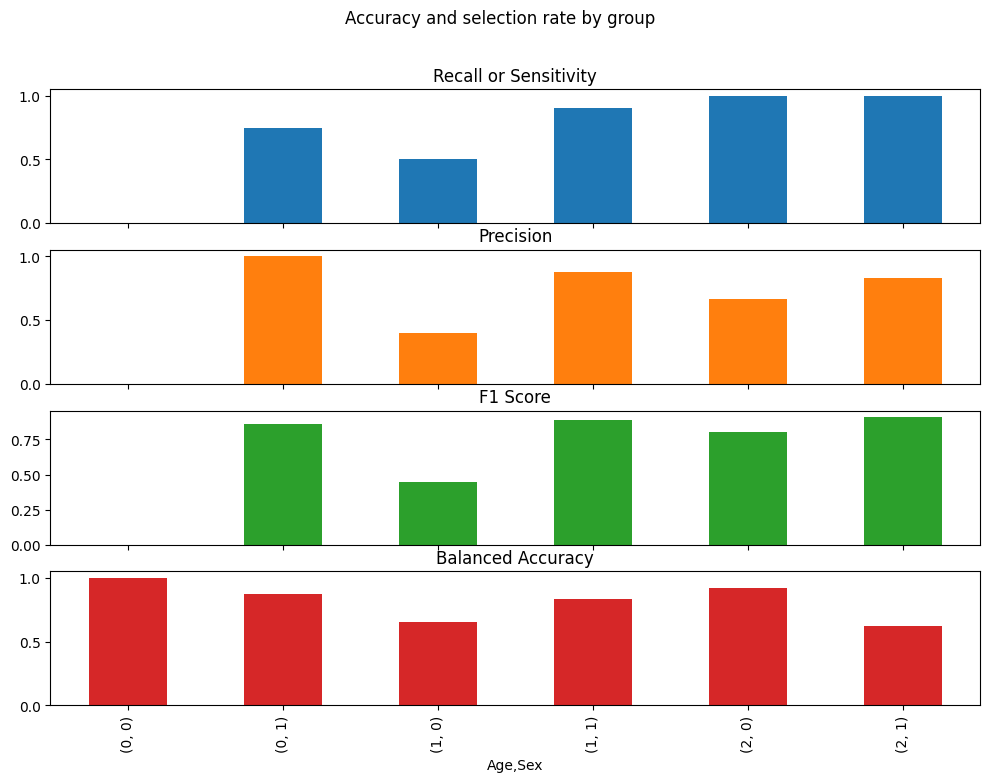

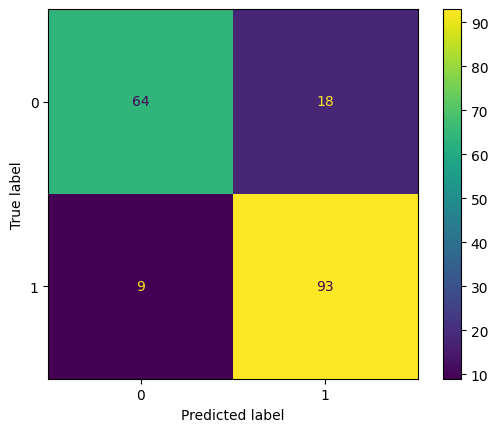

              precision    recall  f1-score   support

           0       0.88      0.78      0.83        82
           1       0.84      0.91      0.87       102

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

Specificity:  {0.7804878048780488}
0.8461262553802008


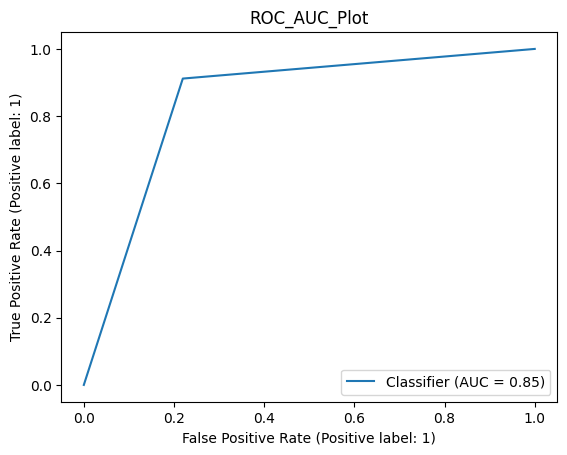

The Age Demographic Parity Difference is: 0.7049689440993789
The Age Demographic Parity Ratio is: 0.16849816849816848
The Sex Demographic Parity Difference is: 0.4513725490196078
The Sex Demographic Parity Ratio is: 0.34266133637921187
The Age Equalized Odds Difference is: 0.5
The Age Equalized Odds Ratio is: 0.0
The Sex Equalized Odds Difference is: 0.26041666666666674
The Sex Equalized Odds Ratio is: 0.5510204081632653
-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.784314
Precision                0.727273
F1 Score                 0.754717
Balanced Accuracy        0.709230
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.333333
    1                 1.000000   0.444444  0.615385           0.772727
1   0                 1.000000   0.266667  0.4210

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.375
The Demographic Parity Ratio is: 0.5
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


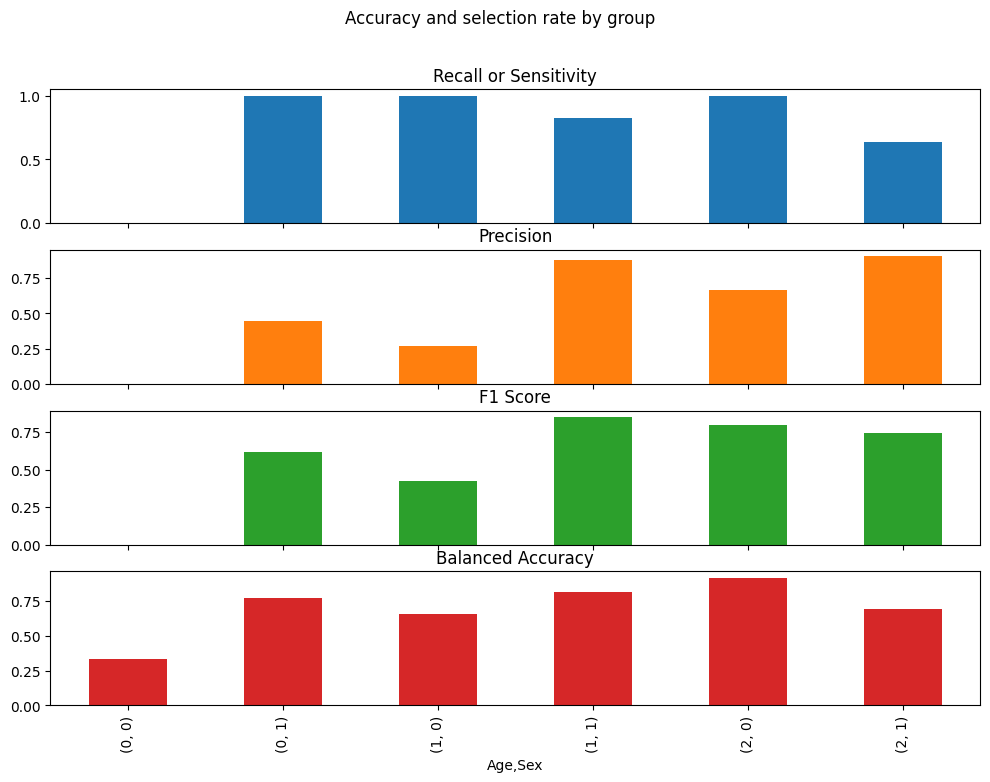

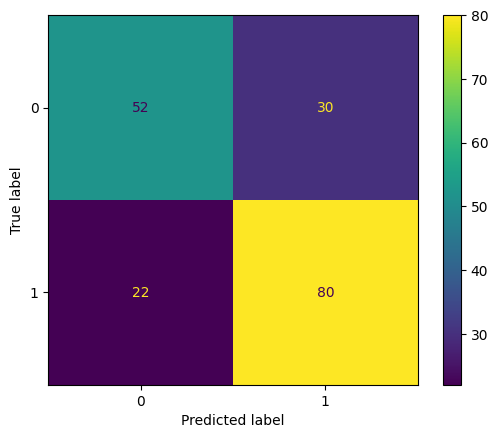

              precision    recall  f1-score   support

           0       0.70      0.63      0.67        82
           1       0.73      0.78      0.75       102

    accuracy                           0.72       184
   macro avg       0.71      0.71      0.71       184
weighted avg       0.72      0.72      0.72       184

Specificity:  {0.6341463414634146}
0.7092300334768052


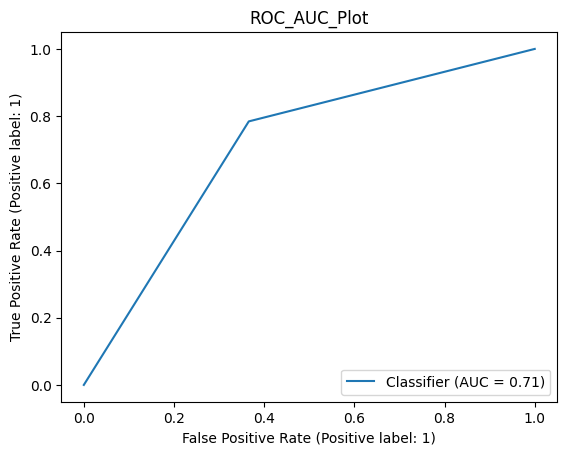

The Age Demographic Parity Difference is: 0.10219249349684134
The Age Demographic Parity Ratio is: 0.836212030970816
The Sex Demographic Parity Difference is: 0.06039215686274513
The Sex Demographic Parity Ratio is: 0.9066666666666666
The Age Equalized Odds Difference is: 0.34375
The Age Equalized Odds Ratio is: 0.4047619047619047
The Sex Equalized Odds Difference is: 0.31216931216931215
The Sex Equalized Odds Ratio is: 0.4537037037037037
--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        37
           1       0.88      0.82      0.85        45

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82

The accuracy for Fold 1 : 0.8435435435435436
The fold is : 1 : 
              precision    recall  f1-score   support

           0

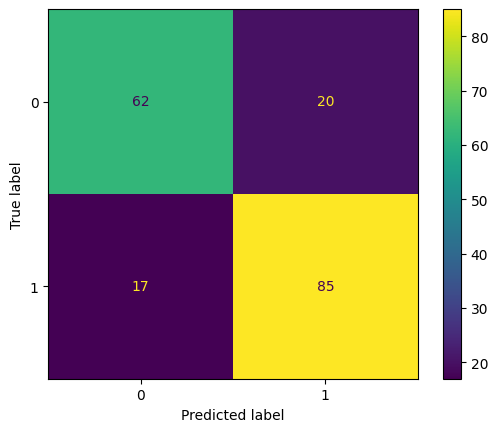

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        82
           1       0.81      0.83      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.79      0.80       184
weighted avg       0.80      0.80      0.80       184

Specificity:  {0.7560975609756098}
0.7947154471544715


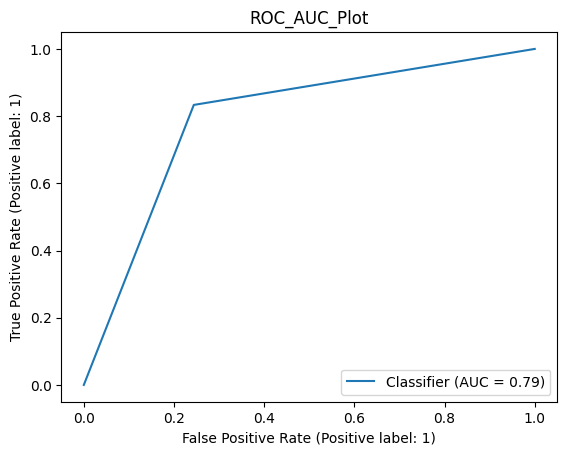

The Age Demographic Parity Difference is: 0.17184265010351962
The Age Demographic Parity Ratio is: 0.7529761904761906
The Sex Demographic Parity Difference is: 0.08666666666666667
The Sex Demographic Parity Ratio is: 0.8522727272727273
The Age Equalized Odds Difference is: 0.2156862745098039
The Age Equalized Odds Ratio is: 0.4761904761904762
The Sex Equalized Odds Difference is: 0.2804232804232804
The Sex Equalized Odds Ratio is: 0.345679012345679


In [13]:
#----------------------------------- LOGISTIC REGRESSION MODEL----------------------------#
print('--------------------------Logistic Regression---------------------------------')
print('--------------------------With CORRELATION----------------------------------')

classifier_lr, y_pred, fair_pred, fair_model= model(LogisticRegression(random_state = 0,C=10,penalty= 'l2'), x_dev, x_test, y_dev, y_test)
print('--------------------------Without CORRELATION----------------------------------')
classifier_lr_fair, y_pred= modelpre(LogisticRegression(random_state = 0,C=10,penalty= 'l2'), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

--------------------------Support Vector Matrix----------------------------------
--------------------------With CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.80      0.89      0.85        37
           1       0.90      0.82      0.86        45

    accuracy                           0.85        82
   macro avg       0.85      0.86      0.85        82
weighted avg       0.86      0.85      0.85        82

The accuracy for Fold 1 : 0.857057057057057
The FAIR accuracy for Fold 1 : 0.7537537537537536
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        37
           1       0.84      0.84      0.84        45

    accuracy                           0.83        82
   macro avg       0.83      0.83      0.83        82
weighted avg       0.83      0.83      0.83        82

The accuracy for Fold 2 : 0.8276276276276276
The FAIR a

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Demographic Parity Difference is: 0.8947368421052632
The Demographic Parity Ratio is: 0.0
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


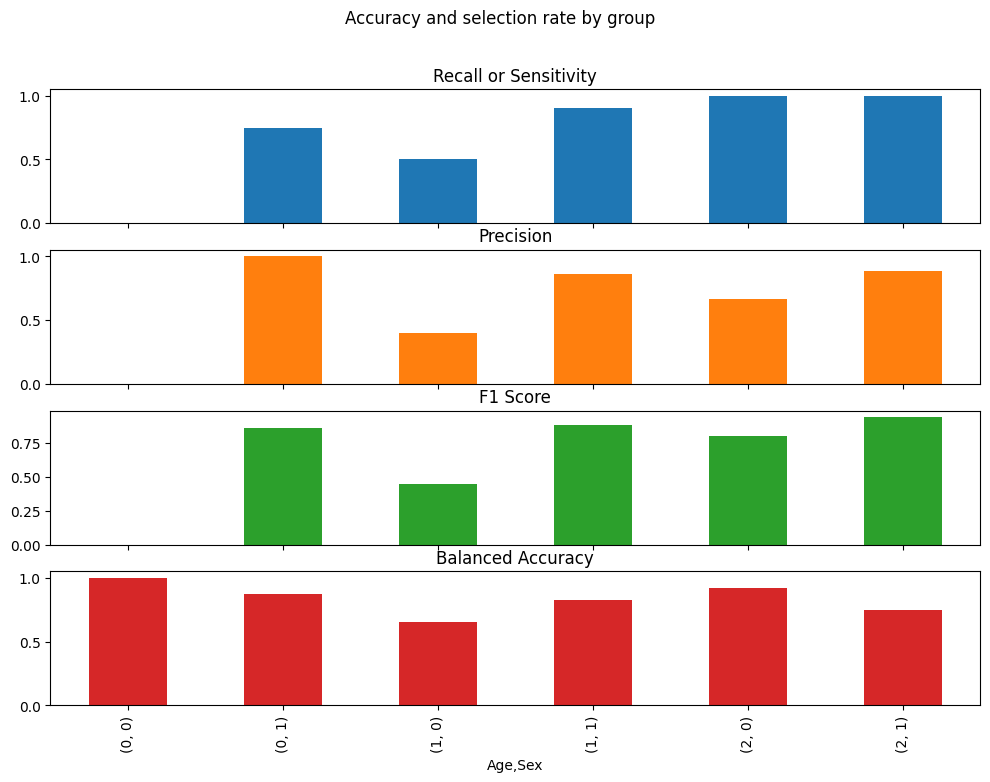

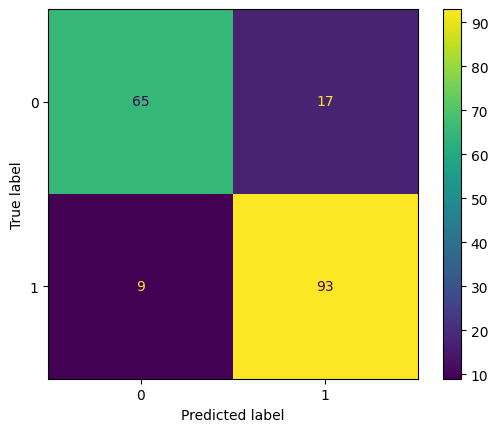

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Specificity:  {0.7926829268292683}
0.8522238163558106


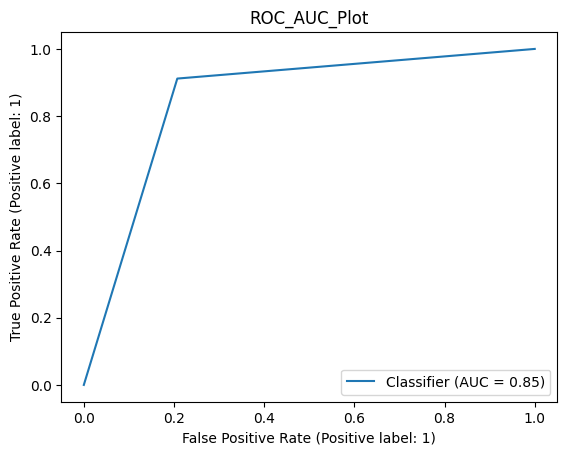

The Age Demographic Parity Difference is: 0.6614906832298137
The Age Demographic Parity Ratio is: 0.17760617760617758
The Sex Demographic Parity Difference is: 0.44470588235294123
The Sex Demographic Parity Ratio is: 0.3460207612456747
The Age Equalized Odds Difference is: 0.35714285714285715
The Age Equalized Odds Ratio is: 0.0
The Sex Equalized Odds Difference is: 0.26041666666666674
The Sex Equalized Odds Ratio is: 0.5934065934065934
-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.745098
Precision                0.716981
F1 Score                 0.730769
Balanced Accuracy        0.689622
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.666667
    1                 0.750000   0.375000  0.500000           0.647727
1   0                 1.000000   

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.36666666666666664
The Demographic Parity Ratio is: 0.4761904761904762
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


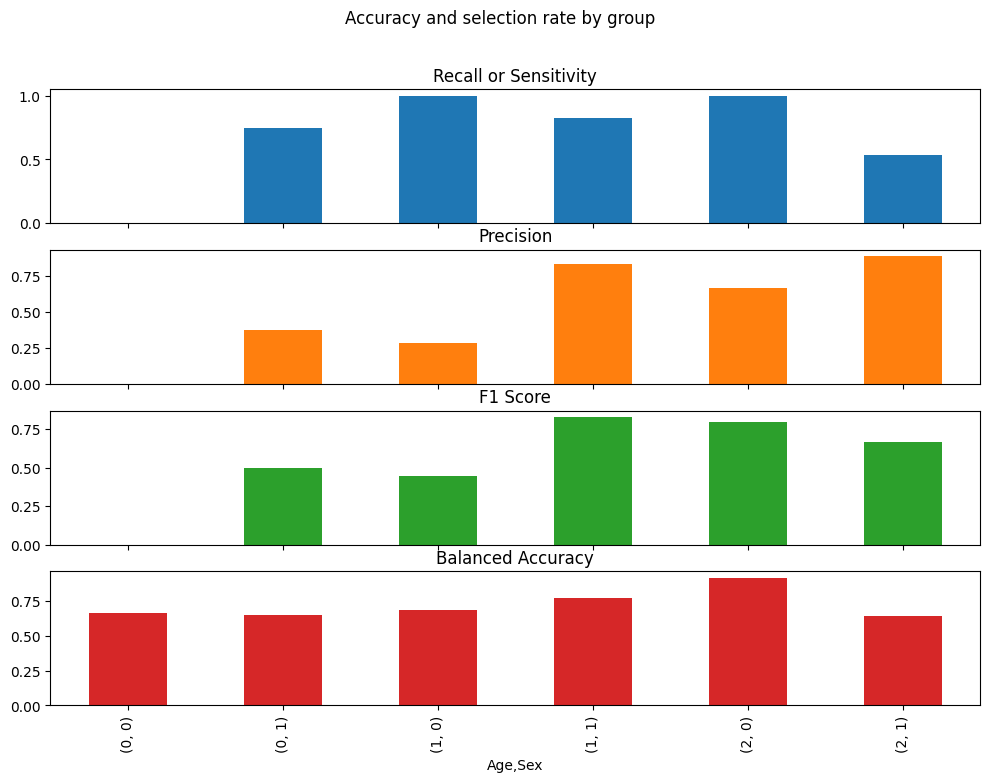

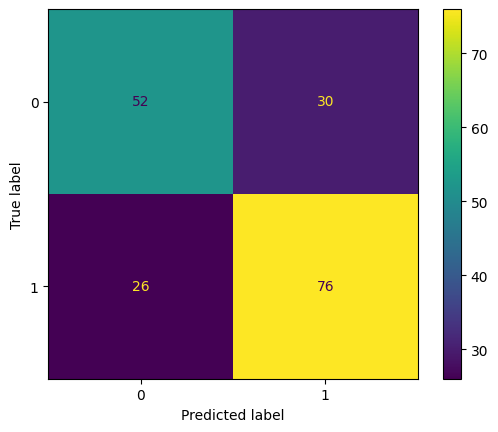

              precision    recall  f1-score   support

           0       0.67      0.63      0.65        82
           1       0.72      0.75      0.73       102

    accuracy                           0.70       184
   macro avg       0.69      0.69      0.69       184
weighted avg       0.69      0.70      0.69       184

Specificity:  {0.6341463414634146}
0.6896221903395505


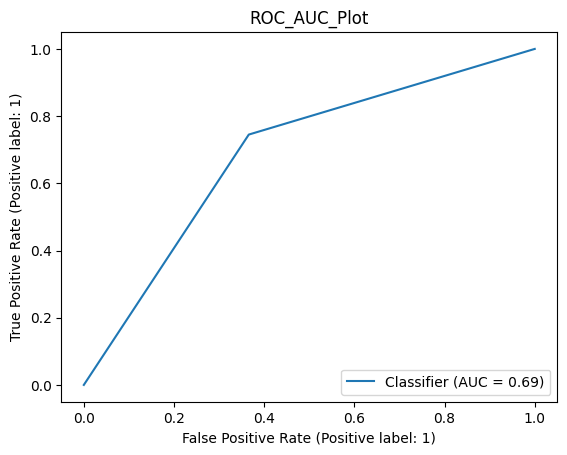

The Age Demographic Parity Difference is: 0.18450390189520632
The Age Demographic Parity Ratio is: 0.7121739130434782
The Sex Demographic Parity Difference is: 0.02117647058823524
The Sex Demographic Parity Ratio is: 0.9634888438133875
The Age Equalized Odds Difference is: 0.27083333333333337
The Age Equalized Odds Ratio is: 0.5204081632653061
The Sex Equalized Odds Difference is: 0.27083333333333337
The Sex Equalized Odds Ratio is: 0.6780626780626781
--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        37
           1       0.88      0.80      0.84        45

    accuracy                           0.83        82
   macro avg       0.83      0.83      0.83        82
weighted avg       0.83      0.83      0.83        82

The accuracy for Fold 1 : 0.8324324324324325
The fold is : 1 : 
              precision    recall  f1-score   support


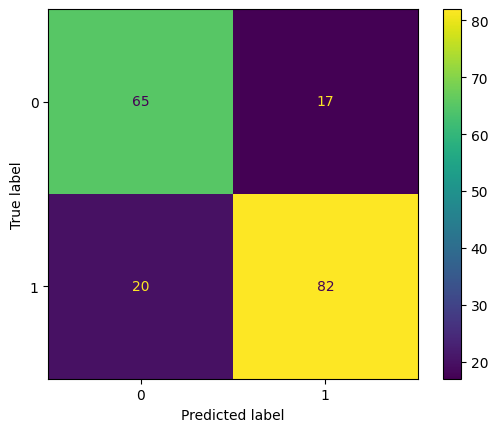

              precision    recall  f1-score   support

           0       0.76      0.79      0.78        82
           1       0.83      0.80      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

Specificity:  {0.7926829268292683}
0.7983022477283597


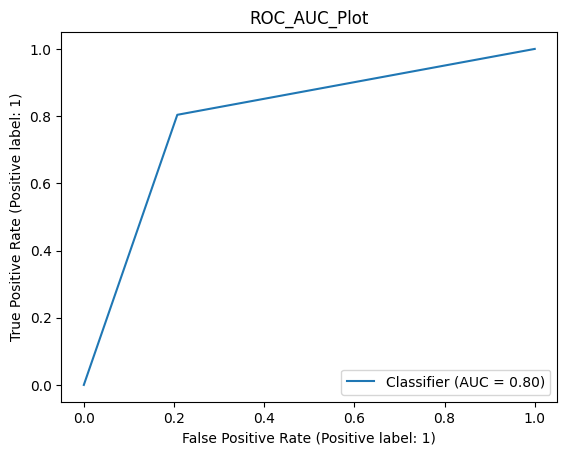

The Age Demographic Parity Difference is: 0.1759834368530021
The Age Demographic Parity Ratio is: 0.7301587301587301
The Sex Demographic Parity Difference is: 0.046666666666666634
The Sex Demographic Parity Ratio is: 0.9146341463414634
The Age Equalized Odds Difference is: 0.24242424242424243
The Age Equalized Odds Ratio is: 0.4047619047619047
The Sex Equalized Odds Difference is: 0.33597883597883593
The Sex Equalized Odds Ratio is: 0.21604938271604937


In [14]:
#----------------------------------- SUPPORT VECTOR MATRIX MODEL -------------------------------------------#
print('--------------------------Support Vector Matrix----------------------------------')
print('--------------------------With CORRELATION----------------------------------')
classifier_svc, y_pred, fair_pred, fair_model= model(SVC(kernel="linear", random_state=0, gamma = 10, C=10, probability= True), x_dev, x_test, y_dev, y_test)
#explain(shap.Explainer(classifier_svc), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_svc_sex, y_pred= modelpre(SVC(kernel="linear", random_state=0, gamma = 10, C=10, probability= True), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

---------------------------Random Forest Vector--------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        37
           1       0.86      0.84      0.85        45

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82

The accuracy for Fold 1 : 0.8411411411411411
The FAIR accuracy for Fold 1 : 0.7132132132132132
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.82      0.83        45

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 2 : 0.8165165165165165
The FAIR accuracy for Fold 2 : 0.721921921921922
The fold is : 2 : 
              precis

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Demographic Parity Difference is: 0.9473684210526315
The Demographic Parity Ratio is: 0.0
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


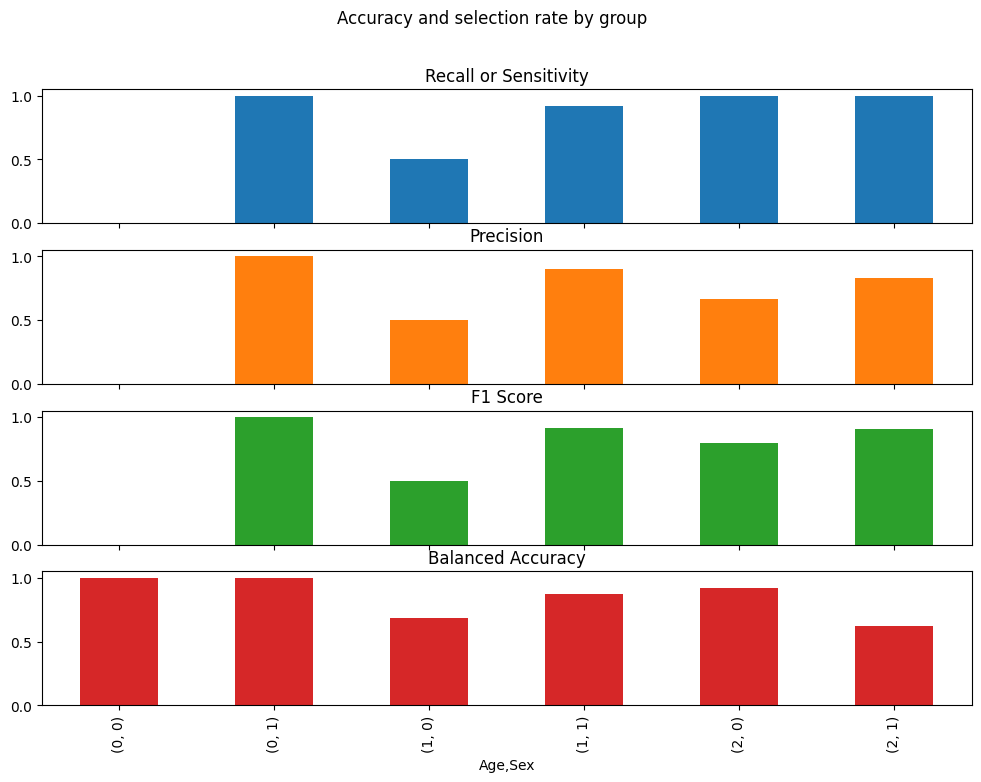

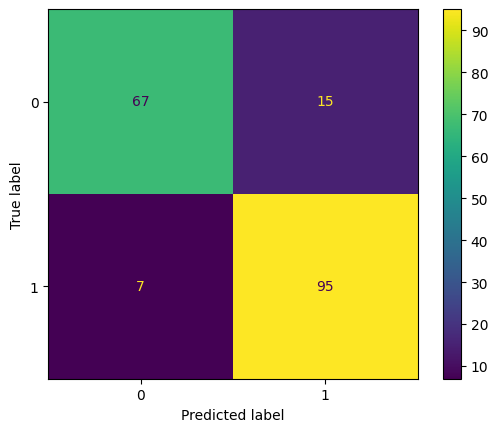

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.86      0.93      0.90       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184

Specificity:  {0.8170731707317073}
0.8742228598756576


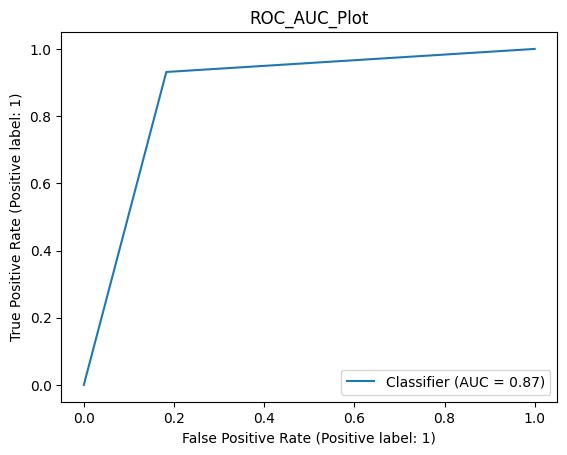

The Age Demographic Parity Difference is: 0.6573498964803313
The Age Demographic Parity Ratio is: 0.22466422466422464
The Sex Demographic Parity Difference is: 0.4807843137254902
The Sex Demographic Parity Ratio is: 0.2998286693318104
The Age Equalized Odds Difference is: 0.5
The Age Equalized Odds Ratio is: 0.0
The Sex Equalized Odds Difference is: 0.28125
The Sex Equalized Odds Ratio is: 0.48214285714285715
-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.852941
Precision                0.737288
F1 Score                 0.790909
Balanced Accuracy        0.737446
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.000000
    1                 1.000000   0.400000  0.571429           0.727273
1   0                 0.750000   0.300000  0.428571          

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.75
The Demographic Parity Ratio is: 0.25
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


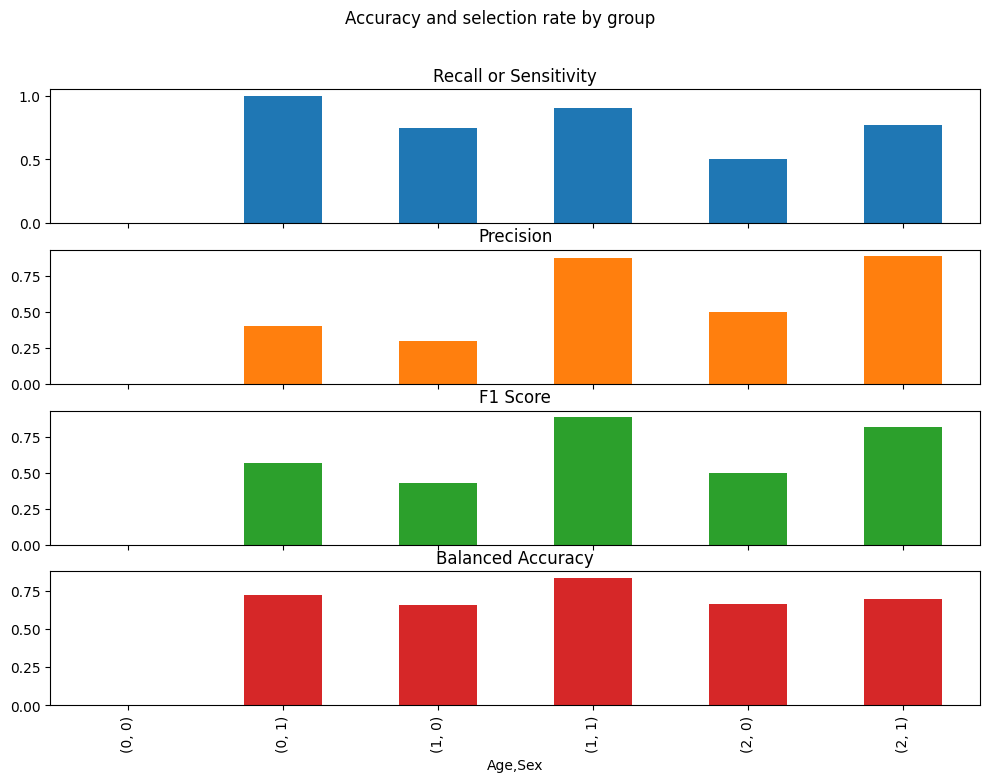

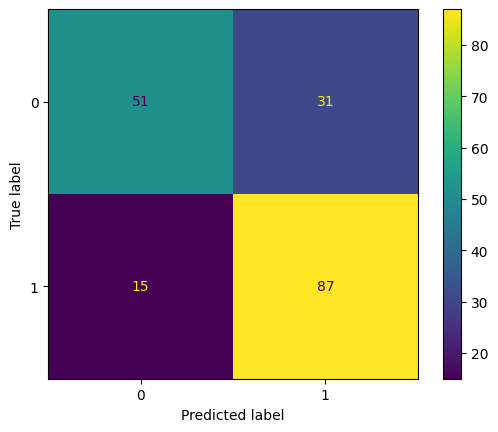

              precision    recall  f1-score   support

           0       0.77      0.62      0.69        82
           1       0.74      0.85      0.79       102

    accuracy                           0.75       184
   macro avg       0.76      0.74      0.74       184
weighted avg       0.75      0.75      0.75       184

Specificity:  {0.6219512195121951}
0.7374461979913918


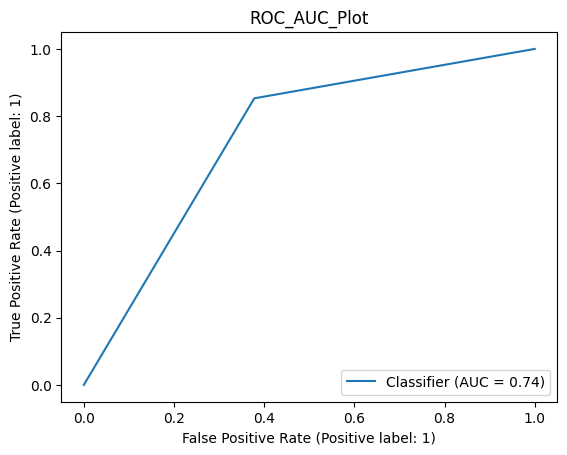

The Age Demographic Parity Difference is: 0.15320910973084878
The Age Demographic Parity Ratio is: 0.798913043478261
The Sex Demographic Parity Difference is: 0.13725490196078427
The Sex Demographic Parity Ratio is: 0.7941176470588236
The Age Equalized Odds Difference is: 0.4201680672268908
The Age Equalized Odds Ratio is: 0.4047619047619047
The Sex Equalized Odds Difference is: 0.19791666666666674
The Sex Equalized Odds Ratio is: 0.6296296296296297
--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        37
           1       0.83      0.84      0.84        45

    accuracy                           0.82        82
   macro avg       0.82      0.81      0.81        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 1 : 0.8141141141141142
The fold is : 1 : 
              precision    recall  f1-score   support

 

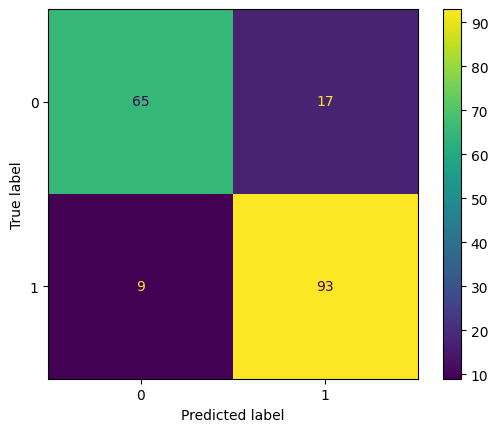

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Specificity:  {0.7926829268292683}
0.8522238163558106


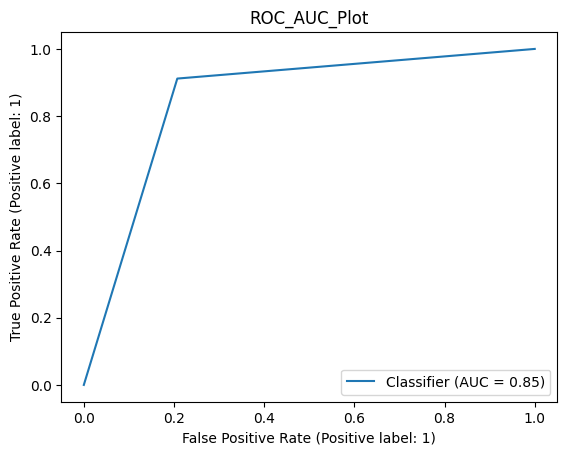

The Age Demographic Parity Difference is: 0.5186335403726708
The Age Demographic Parity Ratio is: 0.35521235521235517
The Sex Demographic Parity Difference is: 0.4807843137254902
The Sex Demographic Parity Ratio is: 0.2998286693318104
The Age Equalized Odds Difference is: 0.31092436974789917
The Age Equalized Odds Ratio is: 0.27450980392156865
The Sex Equalized Odds Difference is: 0.4375
The Sex Equalized Odds Ratio is: 0.5333333333333333


In [15]:
#-------------------------------------- RANDOM FOREST CLASSIFIER ----------------------------------------#
print('---------------------------Random Forest Vector--------------------------------')
classifier_rf, y_pred, fair_pred, fair_model= model(RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=5, max_depth=10), x_dev, x_test, y_dev, y_test)
#explain(shap.Explainer(classifier_rf), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_rf_fair, y_pred= modelpre(RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=5, max_depth=10),x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)


-----------------------------K Nearest Neighbor-----------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        37
           1       0.83      0.87      0.85        45

    accuracy                           0.83        82
   macro avg       0.83      0.83      0.83        82
weighted avg       0.83      0.83      0.83        82

The accuracy for Fold 1 : 0.8252252252252252
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        37
           1       0.87      0.87      0.87        45

    accuracy                           0.85        82
   macro avg       0.85      0.85      0.85        82
weighted avg       0.85      0.85      0.85        82

The accuracy for Fold 2 : 0.8522522522522522
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        37
           1 

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.9210526315789473
The Demographic Parity Ratio is: 0.0
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


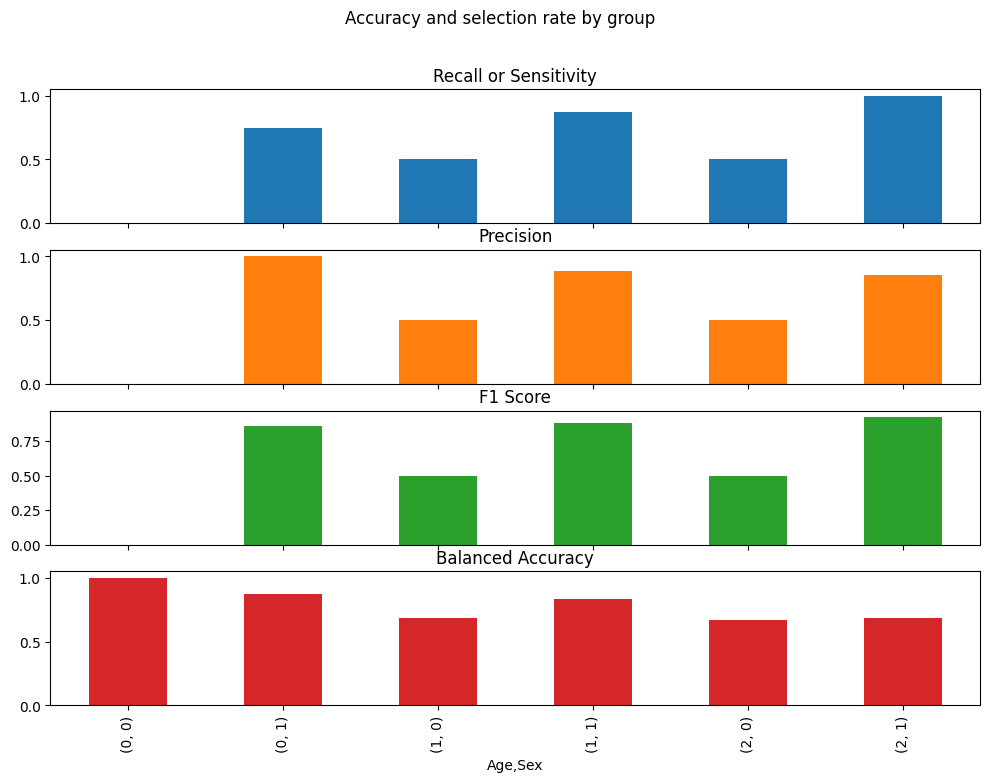

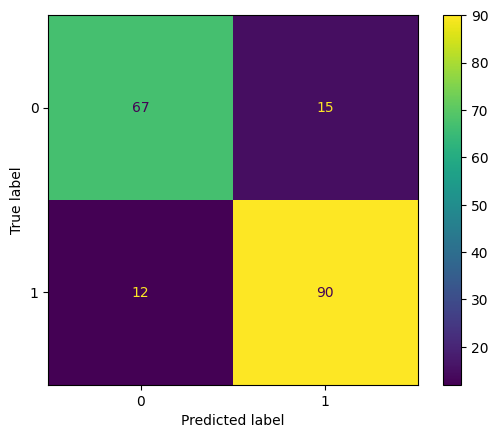

              precision    recall  f1-score   support

           0       0.85      0.82      0.83        82
           1       0.86      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Specificity:  {0.8170731707317073}
0.849713055954089


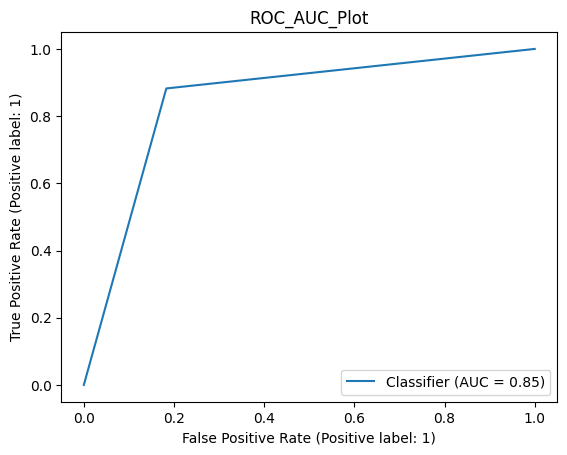

The Age Demographic Parity Difference is: 0.6614906832298137
The Age Demographic Parity Ratio is: 0.17760617760617758
The Sex Demographic Parity Difference is: 0.4835294117647059
The Sex Demographic Parity Ratio is: 0.26737967914438504
The Age Equalized Odds Difference is: 0.42857142857142855
The Age Equalized Odds Ratio is: 0.0
The Sex Equalized Odds Difference is: 0.40625
The Sex Equalized Odds Ratio is: 0.48214285714285715
--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        37
           1       0.82      0.82      0.82        45

    accuracy                           0.80        82
   macro avg       0.80      0.80      0.80        82
weighted avg       0.80      0.80      0.80        82

The accuracy for Fold 1 : 0.803003003003003
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.78   

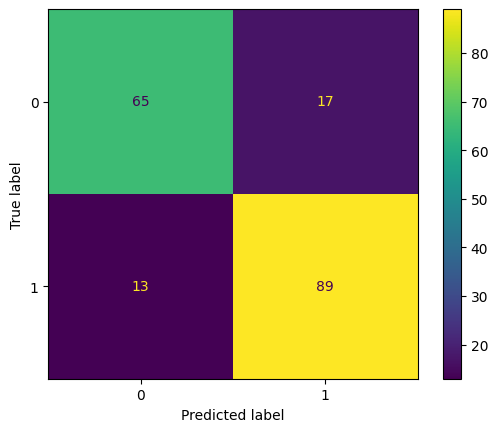

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        82
           1       0.84      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184

Specificity:  {0.7926829268292683}
0.8326159732185557


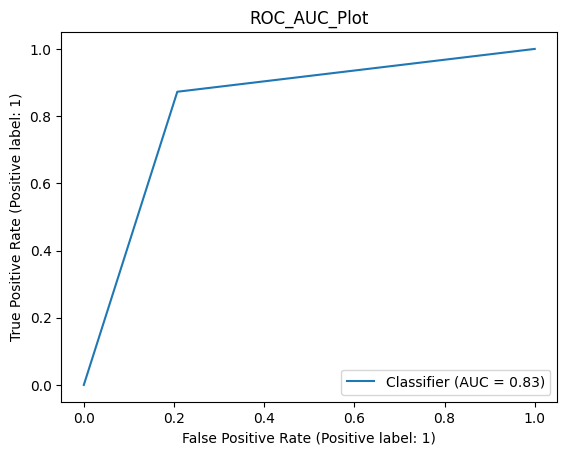

The Age Demographic Parity Difference is: 0.43167701863354035
The Age Demographic Parity Ratio is: 0.39826839826839827
The Sex Demographic Parity Difference is: 0.3098039215686274
The Sex Demographic Parity Ratio is: 0.5108359133126935
The Age Equalized Odds Difference is: 0.1680672268907563
The Age Equalized Odds Ratio is: 0.411764705882353
The Sex Equalized Odds Difference is: 0.39583333333333337
The Sex Equalized Odds Ratio is: 0.5581395348837209


In [18]:
#------------------------------------  K-NEAREST NEIGHBBOR ------------------------------------------#
print('-----------------------------K Nearest Neighbor-----------------------------')
classifier_knn, y_pred= modelnoMitigation(KNeighborsClassifier(n_neighbors=5), x_dev, x_test, y_dev, y_test)
#explain(shap.Explainer(classifier_knn), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_knn_fair, y_pred= modelpre(KNeighborsClassifier(n_neighbors=5), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

---------------------------------------Ada Boost-----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        37
           1       0.87      0.76      0.81        45

    accuracy                           0.80        82
   macro avg       0.81      0.81      0.80        82
weighted avg       0.81      0.80      0.81        82

The accuracy for Fold 1 : 0.8102102102102102
The FAIR accuracy for Fold 1 : 0.67987987987988
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        37
           1       0.80      0.82      0.81        45

    accuracy                           0.79        82
   macro avg       0.79      0.79      0.79        82
weighted avg       0.79      0.79      0.79        82

The accuracy for Fold 2 : 0.7894894894894895
The FAIR accuracy for Fold 2 : 0.7537537537537536
The fold is : 2 : 
              precision    re

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


The Demographic Parity Difference is: 0.5701754385964912
The Demographic Parity Ratio is: 0.2261904761904762
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


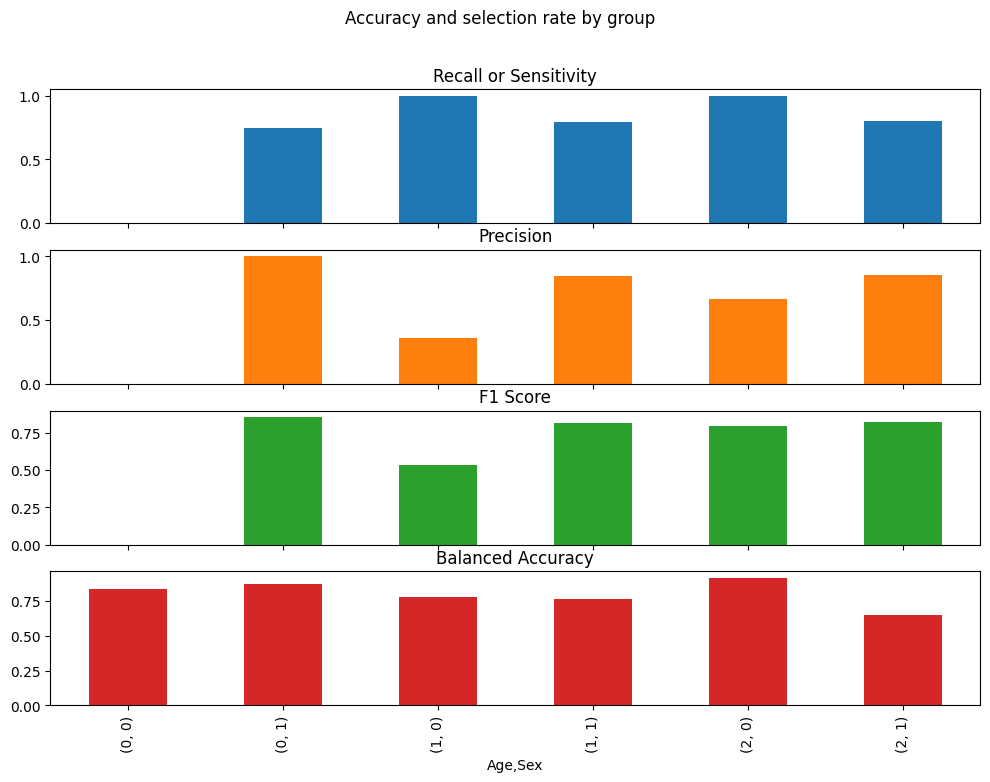

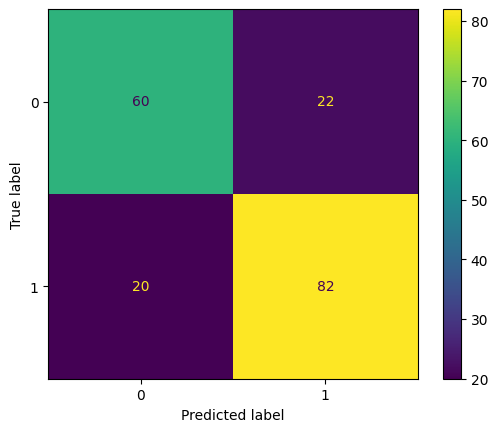

              precision    recall  f1-score   support

           0       0.75      0.73      0.74        82
           1       0.79      0.80      0.80       102

    accuracy                           0.77       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.77      0.77      0.77       184

Specificity:  {0.7317073170731707}
0.7678144428503109


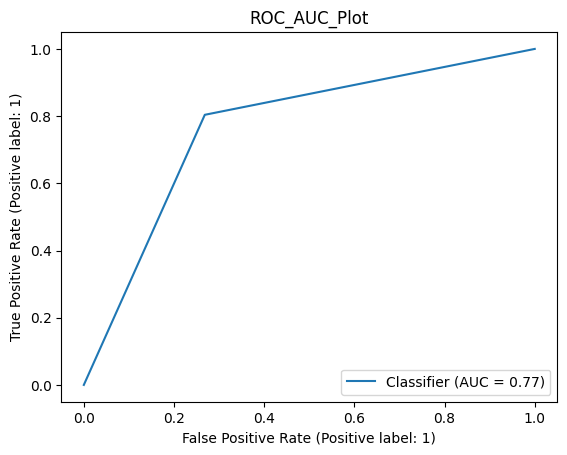

The Age Demographic Parity Difference is: 0.4834368530020704
The Age Demographic Parity Ratio is: 0.282642089093702
The Sex Demographic Parity Difference is: 0.1521568627450981
The Sex Demographic Parity Ratio is: 0.7435558493060145
The Age Equalized Odds Difference is: 0.29831932773109243
The Age Equalized Odds Ratio is: 0.16470588235294117
The Sex Equalized Odds Difference is: 0.20833333333333337
The Sex Equalized Odds Ratio is: 0.7489711934156378
-----------------------Fair Model-------------------------


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


OVERALL METRICS
Recall or Sensitivity    0.578431
Precision                0.655556
F1 Score                 0.614583
Balanced Accuracy        0.600191
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.833333
    1                 0.750000   0.375000  0.500000           0.647727
1   0                 0.250000   0.125000  0.166667           0.406250
    1                 0.580645   0.720000  0.642857           0.590323
2   0                 1.000000   0.666667  0.800000           0.916667
    1                 0.566667   0.850000  0.680000           0.595833
---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.3666666666666667
The Demographic Parity Ratio is: 0.3125
The Equalized Odds Difference is: 1.0
The Equalized Odd

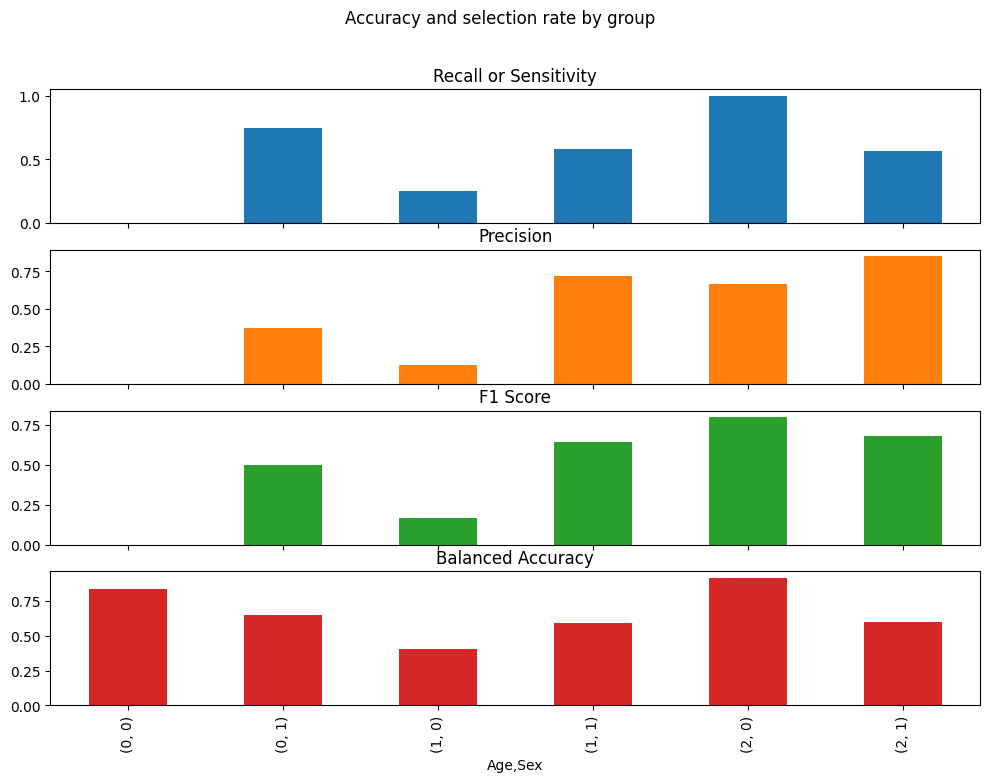

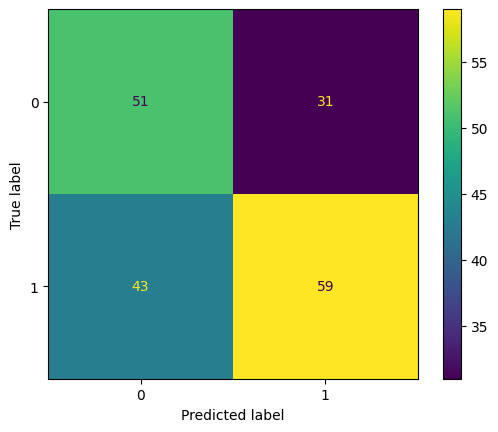

              precision    recall  f1-score   support

           0       0.54      0.62      0.58        82
           1       0.66      0.58      0.61       102

    accuracy                           0.60       184
   macro avg       0.60      0.60      0.60       184
weighted avg       0.61      0.60      0.60       184

Specificity:  {0.6219512195121951}
0.6001912960306074


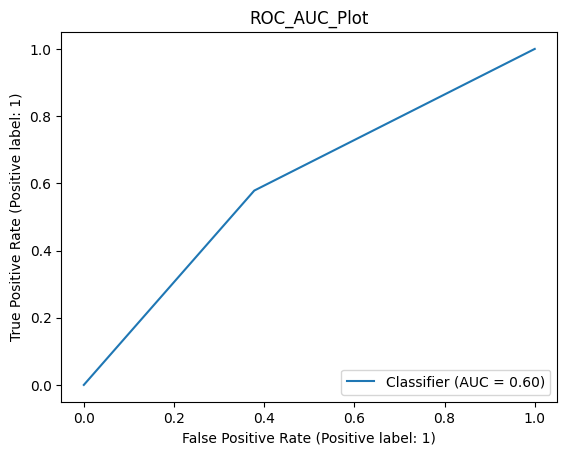

The Age Demographic Parity Difference is: 0.07142857142857145
The Age Demographic Parity Ratio is: 0.8571428571428571
The Sex Demographic Parity Difference is: 0.16705882352941176
The Sex Demographic Parity Ratio is: 0.6787330316742082
The Age Equalized Odds Difference is: 0.18939393939393945
The Age Equalized Odds Ratio is: 0.6938775510204082
The Sex Equalized Odds Difference is: 0.08597883597883593
The Sex Equalized Odds Ratio is: 0.7889610389610391
--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.65      0.89      0.75        37
           1       0.87      0.60      0.71        45

    accuracy                           0.73        82
   macro avg       0.76      0.75      0.73        82
weighted avg       0.77      0.73      0.73        82

The accuracy for Fold 1 : 0.745945945945946
The fold is : 1 : 
              precision    recall  f1-score   support



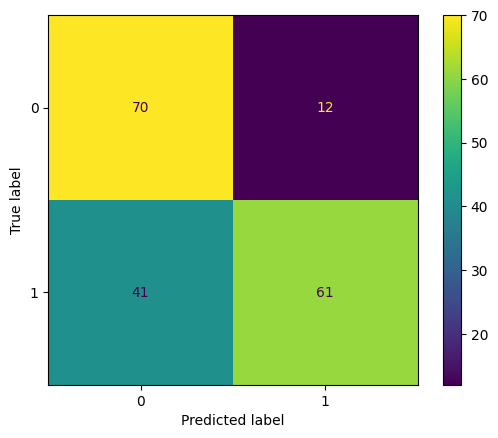

              precision    recall  f1-score   support

           0       0.63      0.85      0.73        82
           1       0.84      0.60      0.70       102

    accuracy                           0.71       184
   macro avg       0.73      0.73      0.71       184
weighted avg       0.74      0.71      0.71       184

Specificity:  {0.8536585365853658}
0.7258488761358202


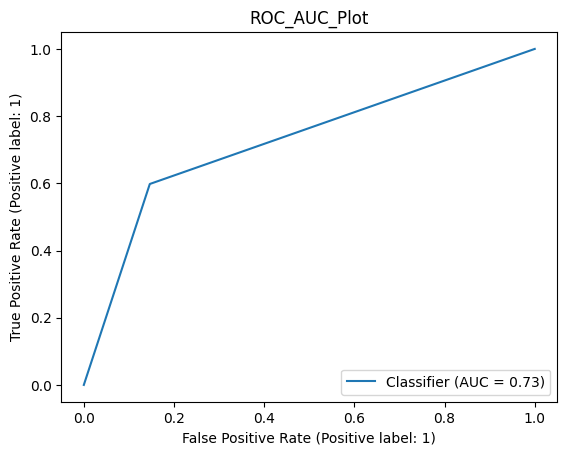

The Age Demographic Parity Difference is: 0.30952380952380953
The Age Demographic Parity Ratio is: 0.38095238095238093
The Sex Demographic Parity Difference is: 0.2701960784313725
The Sex Demographic Parity Ratio is: 0.39508340649692714
The Age Equalized Odds Difference is: 0.18939393939393945
The Age Equalized Odds Ratio is: 0.3333333333333333
The Sex Equalized Odds Difference is: 0.10416666666666663
The Sex Equalized Odds Ratio is: 0.6428571428571429


In [19]:
#-------------------------------------- ADABOOST ----------------------------------------#
# hyperparameter tuning
print('---------------------------------------Ada Boost-----------------------')
classifier_adab, y_pred, fair_pred, fair_model= model(AdaBoostClassifier(random_state=0, n_estimators=100, learning_rate=0.001), x_dev, x_test, y_dev, y_test )
#explain(shap.Explainer(classifier_adab), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_adab_fair, y_pred= modelpre(AdaBoostClassifier(random_state=0, n_estimators=100, learning_rate=0.001),x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

---------------------------------------GradientBoostingClassifier-----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.97      0.82      0.89        45

    accuracy                           0.89        82
   macro avg       0.90      0.90      0.89        82
weighted avg       0.90      0.89      0.89        82

The accuracy for Fold 1 : 0.8975975975975976
The FAIR accuracy for Fold 1 : 0.7894894894894895
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.88      0.84      0.86        45

    accuracy                           0.85        82
   macro avg       0.85      0.85      0.85        82
weighted avg       0.86      0.85      0.85        82

The accuracy for Fold 2 : 0.8546546546546548
The FAIR accuracy for Fold 2 : 0.7648648648648648
The fold is : 2 : 
          

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Demographic Parity Difference is: 0.9210526315789473
The Demographic Parity Ratio is: 0.0
The Equalized Odds Difference is: 0.9666666666666667
The Equalized Odds Ratio is: 0.0


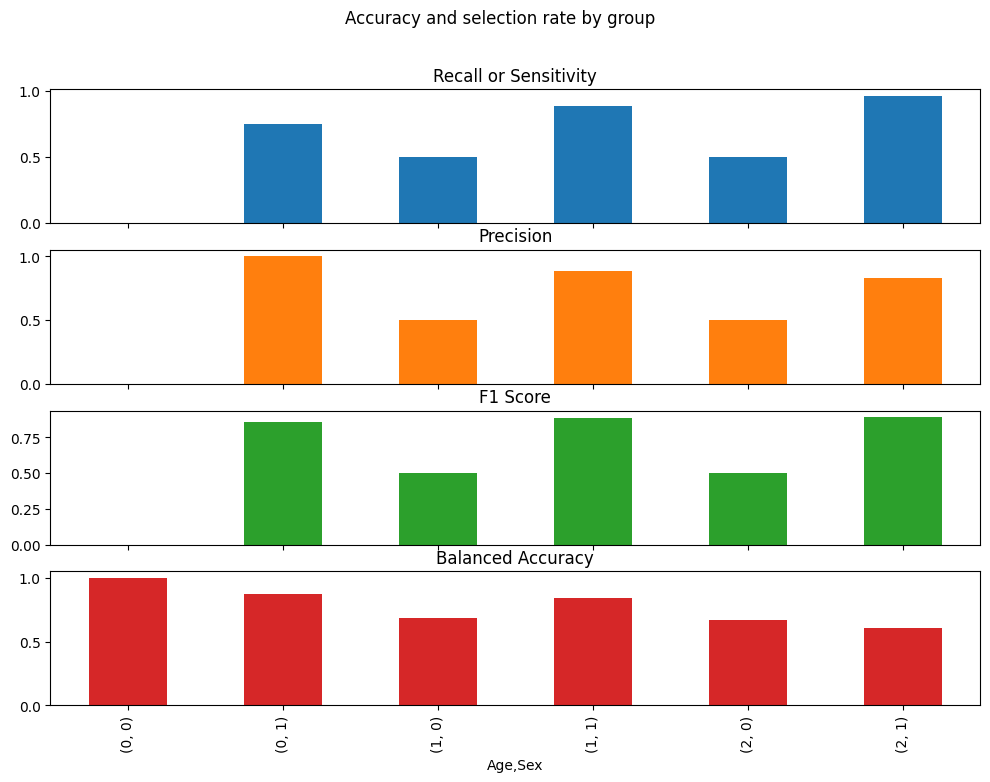

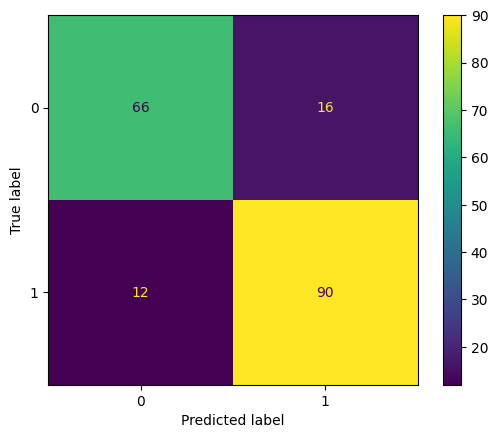

              precision    recall  f1-score   support

           0       0.85      0.80      0.83        82
           1       0.85      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184

Specificity:  {0.8048780487804879}
0.8436154949784792


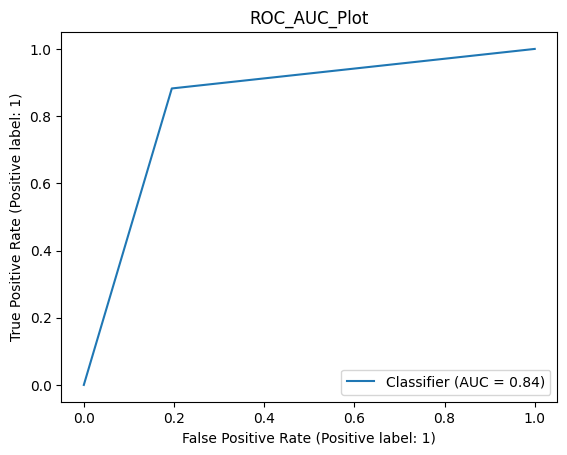

The Age Demographic Parity Difference is: 0.6614906832298137
The Age Demographic Parity Ratio is: 0.17760617760617758
The Sex Demographic Parity Difference is: 0.4901960784313725
The Sex Demographic Parity Ratio is: 0.26470588235294124
The Age Equalized Odds Difference is: 0.5
The Age Equalized Odds Ratio is: 0.0
The Sex Equalized Odds Difference is: 0.40625
The Sex Equalized Odds Ratio is: 0.44505494505494503
-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.745098
Precision                0.703704
F1 Score                 0.723810
Balanced Accuracy        0.677427
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.000000
    1                 1.000000   0.571429  0.727273           0.863636
1   0                 1.000000   0.266667  0.421053         

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.625
The Demographic Parity Ratio is: 0.375
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


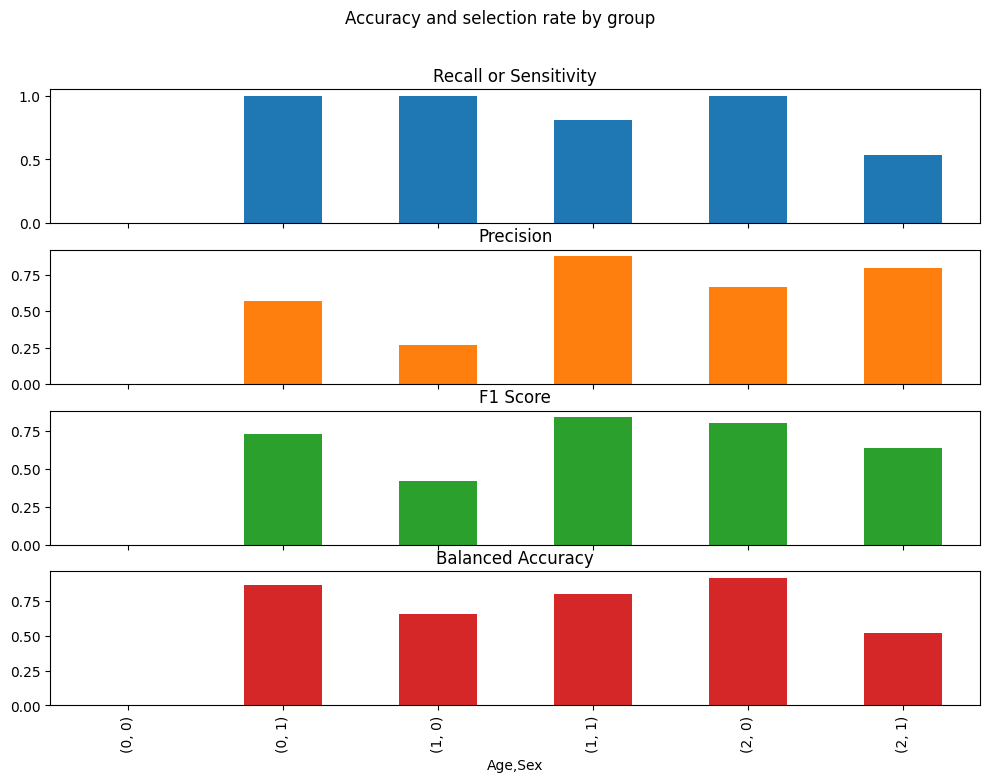

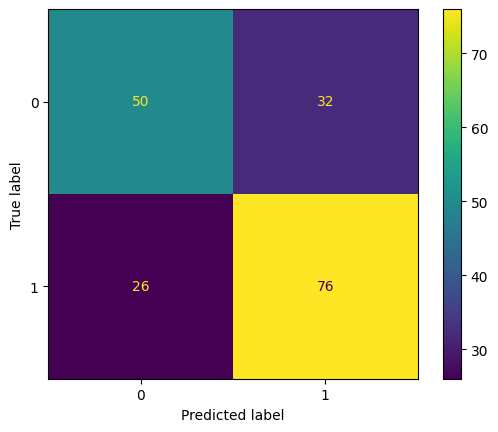

              precision    recall  f1-score   support

           0       0.66      0.61      0.63        82
           1       0.70      0.75      0.72       102

    accuracy                           0.68       184
   macro avg       0.68      0.68      0.68       184
weighted avg       0.68      0.68      0.68       184

Specificity:  {0.6097560975609756}
0.6774270683883309


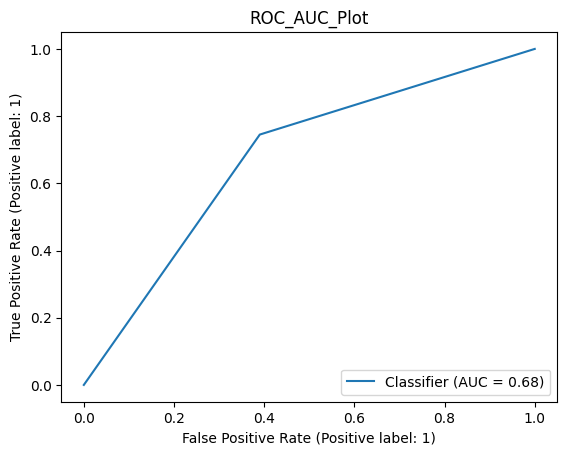

The Age Demographic Parity Difference is: 0.11904761904761907
The Age Demographic Parity Ratio is: 0.8076923076923077
The Sex Demographic Parity Difference is: 0.14588235294117646
The Sex Demographic Parity Ratio is: 0.7933333333333333
The Age Equalized Odds Difference is: 0.4375
The Age Equalized Odds Ratio is: 0.5625
The Sex Equalized Odds Difference is: 0.38359788359788366
The Sex Equalized Odds Ratio is: 0.4032921810699588
--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        37
           1       0.93      0.84      0.88        45

    accuracy                           0.88        82
   macro avg       0.88      0.88      0.88        82
weighted avg       0.88      0.88      0.88        82

The accuracy for Fold 1 : 0.8816816816816817
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79 

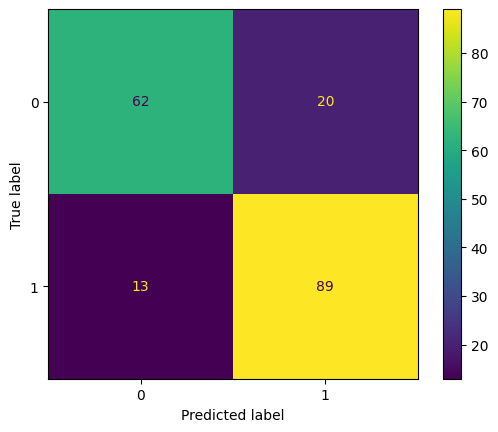

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        82
           1       0.82      0.87      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184

Specificity:  {0.7560975609756098}
0.8143232902917265


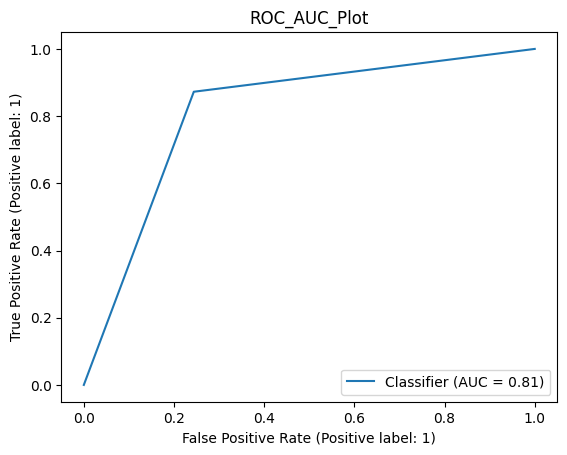

The Age Demographic Parity Difference is: 0.5186335403726708
The Age Demographic Parity Ratio is: 0.35521235521235517
The Sex Demographic Parity Difference is: 0.4380392156862745
The Sex Demographic Parity Ratio is: 0.34944670937682004
The Age Equalized Odds Difference is: 0.31092436974789917
The Age Equalized Odds Ratio is: 0.27450980392156865
The Sex Equalized Odds Difference is: 0.21875
The Sex Equalized Odds Ratio is: 0.48214285714285715


In [20]:
#-------------------------------------- GRADIENT BOOSTING CLASSIFIER ----------------------------------------#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
print('---------------------------------------GradientBoostingClassifier-----------------------')
classifier_gbc, y_pred, fair_pred, fair_model= model(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), x_dev, x_test, y_dev, y_test )
#explain(shap.Explainer(classifier_gbc), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_gbc_fair, y_pred= modelpre(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

---------------------------------------MLP Classifier----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.82      0.83        45

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 1 : 0.8165165165165165
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.67      0.81      0.73        37
           1       0.81      0.67      0.73        45

    accuracy                           0.73        82
   macro avg       0.74      0.74      0.73        82
weighted avg       0.75      0.73      0.73        82

The accuracy for Fold 2 : 0.7387387387387386
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        37
           1  

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Demographic Parity Difference is: 0.8421052631578947
The Demographic Parity Ratio is: 0.0
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


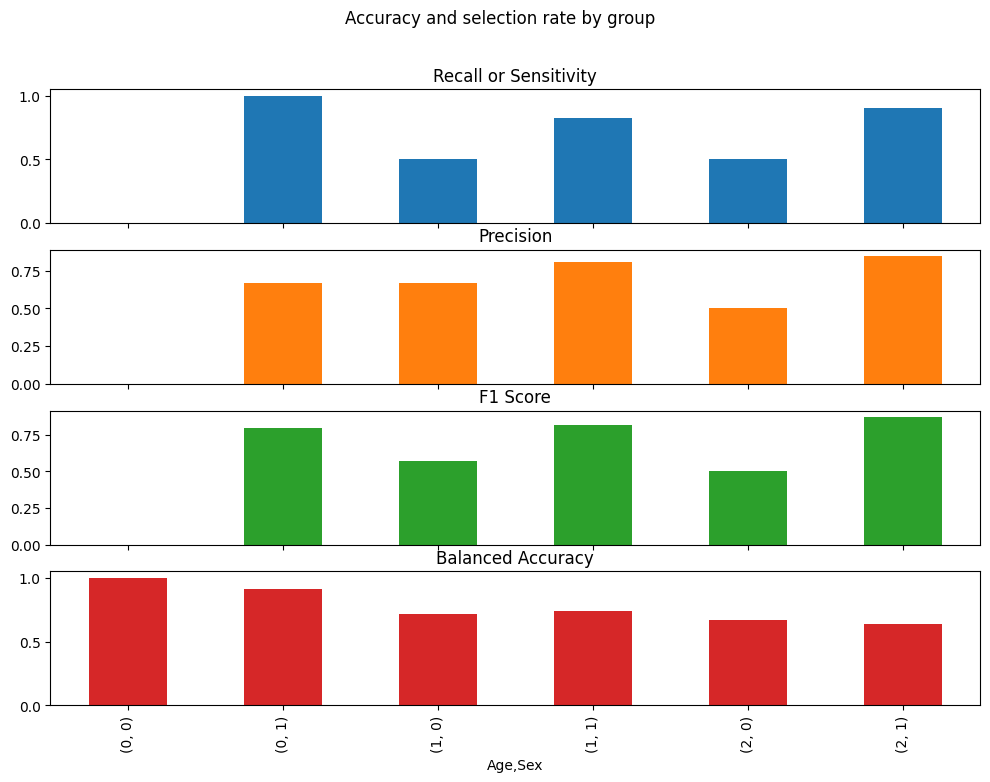

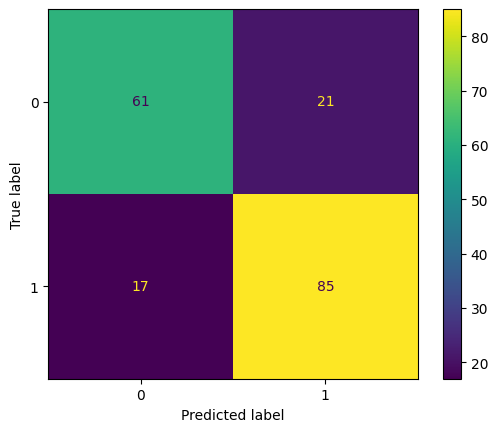

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        82
           1       0.80      0.83      0.82       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184

Specificity:  {0.7439024390243902}
0.7886178861788619


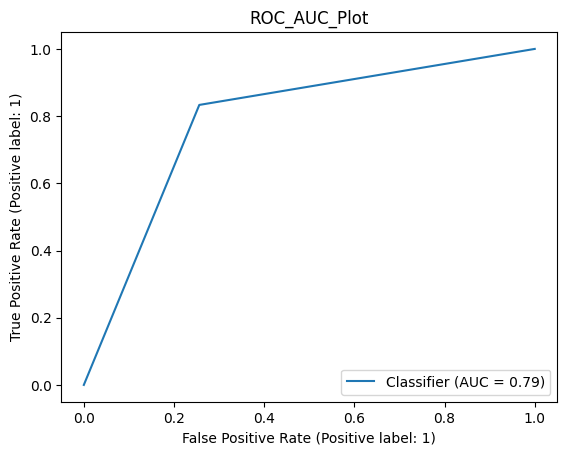

The Age Demographic Parity Difference is: 0.45341614906832295
The Age Demographic Parity Ratio is: 0.3865546218487395
The Sex Demographic Parity Difference is: 0.5262745098039215
The Sex Demographic Parity Ratio is: 0.21840419336051253
The Age Equalized Odds Difference is: 0.31092436974789917
The Age Equalized Odds Ratio is: 0.27450980392156865
The Sex Equalized Odds Difference is: 0.35416666666666663
The Sex Equalized Odds Ratio is: 0.20300751879699247
--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        37
           1       0.76      0.71      0.74        45

    accuracy                           0.72        82
   macro avg       0.72      0.72      0.72        82
weighted avg       0.72      0.72      0.72        82

The accuracy for Fold 1 : 0.7204204204204205
The fold is : 1 : 
              precision    recall  f1-score   suppor

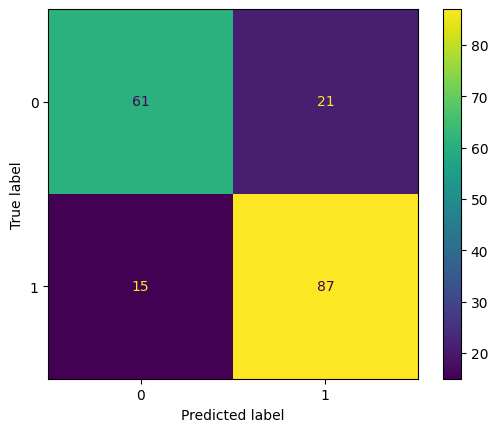

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        82
           1       0.81      0.85      0.83       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

Specificity:  {0.7439024390243902}
0.7984218077474893


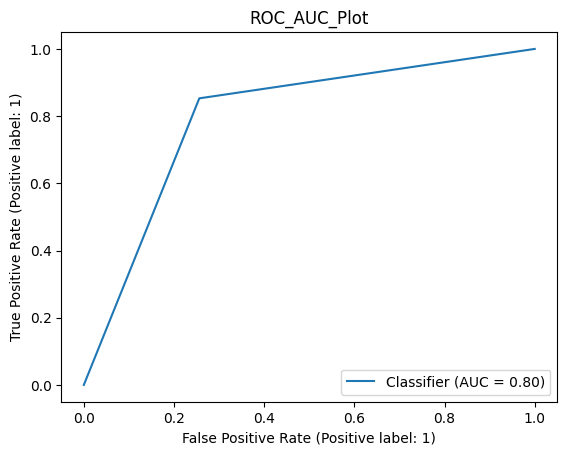

The Age Demographic Parity Difference is: 0.40993788819875776
The Age Demographic Parity Ratio is: 0.4107142857142857
The Sex Demographic Parity Difference is: 0.39529411764705885
The Sex Demographic Parity Ratio is: 0.40106951871657753
The Age Equalized Odds Difference is: 0.18067226890756302
The Age Equalized Odds Ratio is: 0.49411764705882355
The Sex Equalized Odds Difference is: 0.375
The Sex Equalized Odds Ratio is: 0.5714285714285714


In [25]:
#-------------------------------------- MULTI-lAYER PERCEPRTION ----------------------------------------#
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
print('---------------------------------------MLP Classifier----------------------')
classifier_mlp, y_pred= modelnoMitigation(MLPClassifier(solver='lbfgs', max_iter=500, hidden_layer_sizes=(50), random_state=0), x_dev, x_test, y_dev, y_test )
#explain(shap.Explainer(classifier_mlp), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_mlp_fair, y_pred= modelpre(MLPClassifier(solver='lbfgs', max_iter=500, hidden_layer_sizes=(50), random_state=0), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

# Explain away
Shapley values

In [80]:
#-------------------------------------EXPLAINABILITY--------------------------------------#
shap.initjs()
def explain(classifier, x_dev, X_test):
    explainer = shap.Explainer(classifier.predict, x_dev)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar", class_names= classifier.classes_)

In [ ]:
# Tree Explainer for random forest, Ada boost, Hist
ex = shap.TreeExplainer(dtree)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Explainer for KNN

# SVC, KNN, Neural use kernel explainers
explainer = shap.KernelExplainer(svc_linear.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)


# Kernel explainer for neural network
explainer = shap.KernelExplainer(nn.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


--------------------------Support Vector Matrix----------------------------------


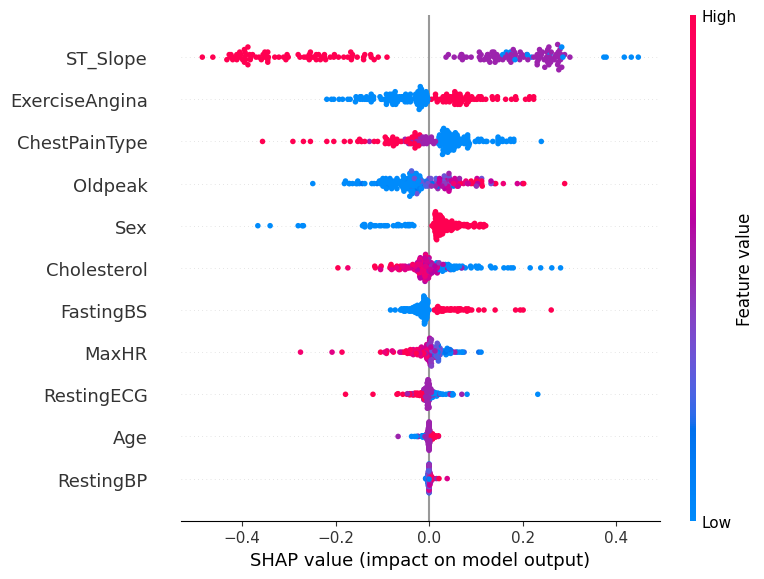

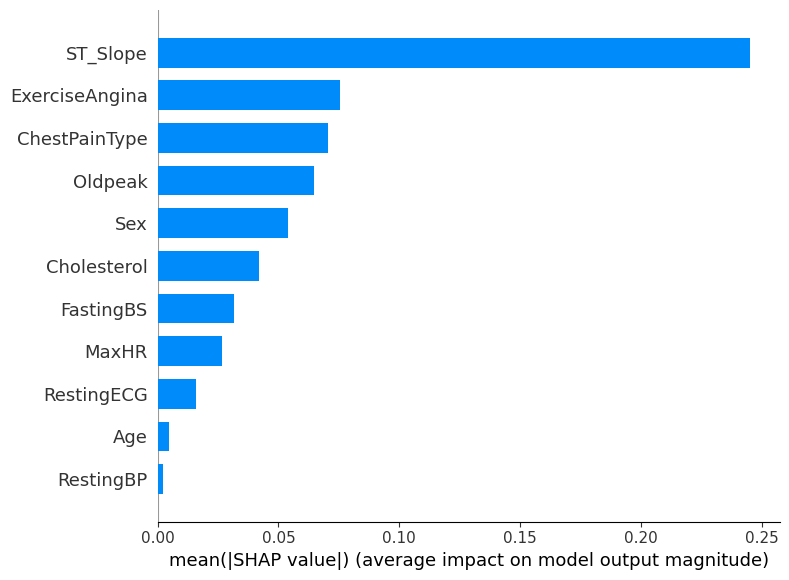

In [88]:
print('--------------------------Support Vector Matrix----------------------------------')
explain(classifier_svc, x_dev, x_test)

---------------------------Random Forest Vector--------------------------------


PermutationExplainer explainer: 185it [00:16,  4.27it/s]                         


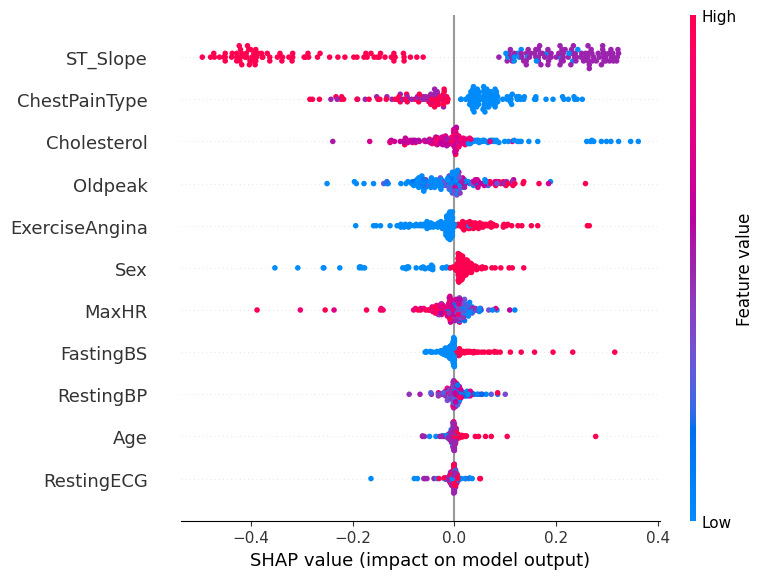

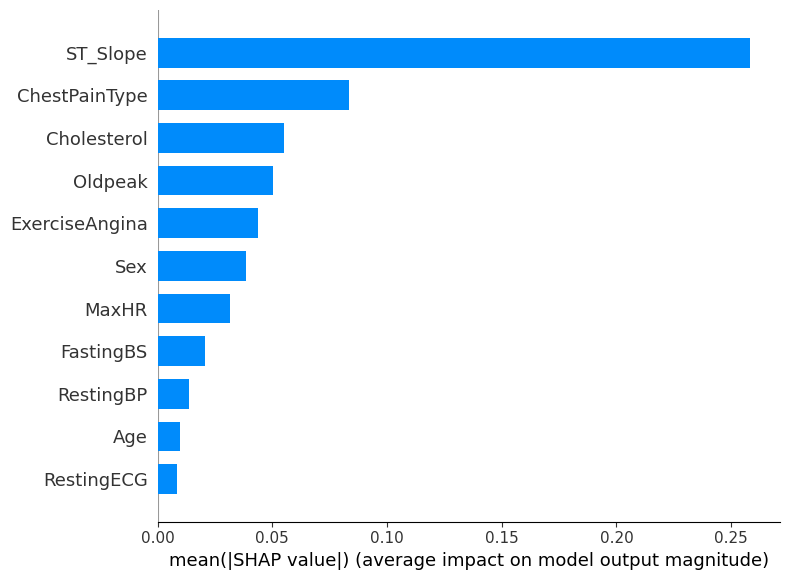

In [81]:
print('---------------------------Random Forest Vector--------------------------------')
# explain(shap.TreeExplainer(classifier_rf), x_test)
# explain(shap.Explainer(classifier_rf.predict, x_dev), x_test)

explain(classifier_rf, x_dev, x_test)

---------------------------Random Forest Vector--------------------------------


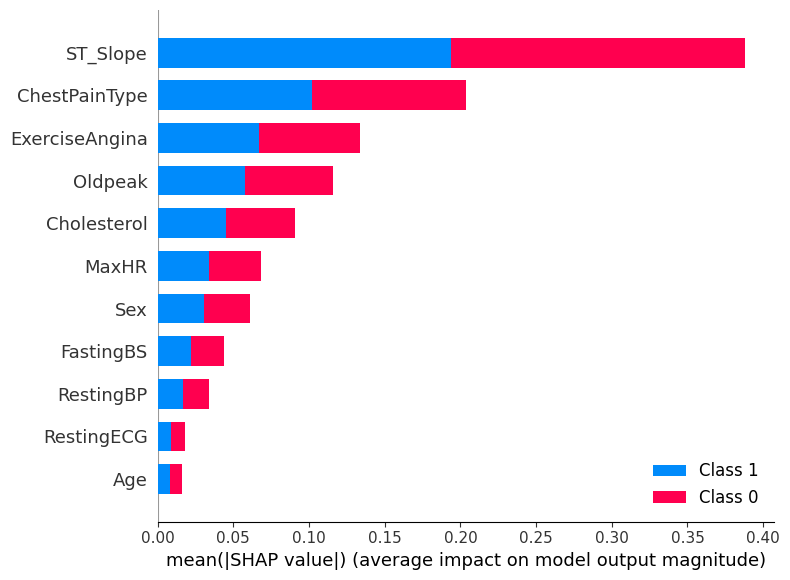

PermutationExplainer explainer: 185it [00:16,  4.41it/s]                         


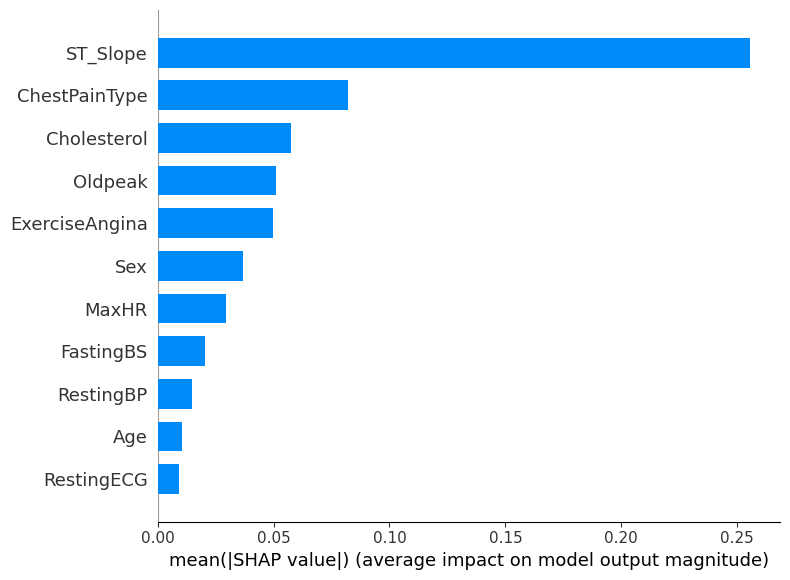

In [ ]:
print('---------------------------Random Forest Vector--------------------------------')
# explain(shap.TreeExplainer(classifier_rf), x_test)
# explain(shap.Explainer(classifier_rf.predict, x_dev), x_test)

explain(classifier_rf, x_dev, x_test)

---------------------------------------GradientBoostingClassifier-----------------------


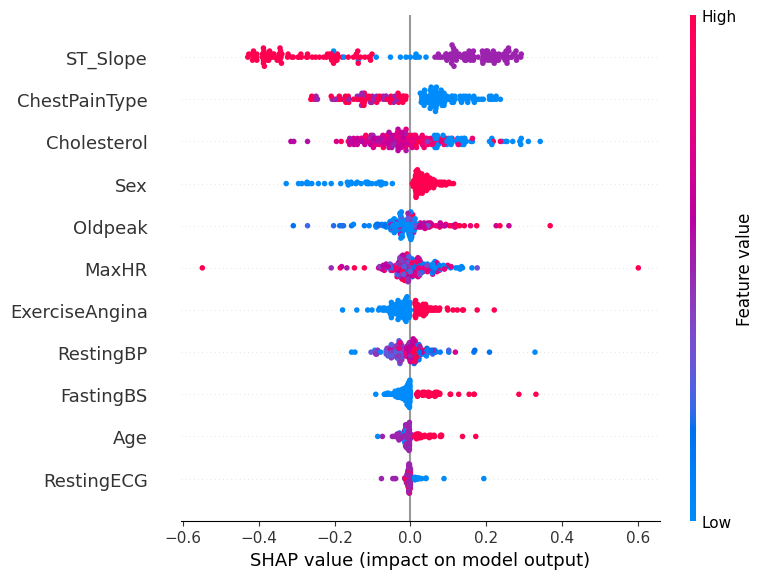

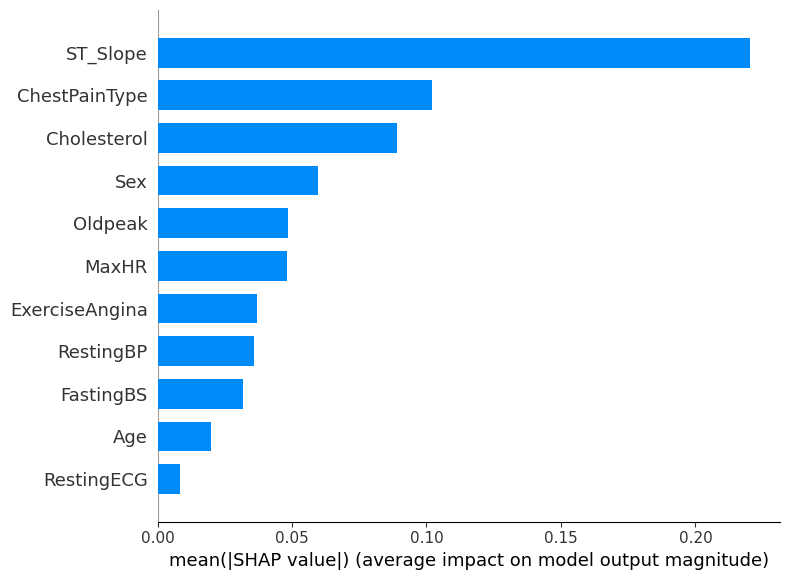

In [82]:
print('---------------------------------------GradientBoostingClassifier-----------------------')
# explain(shap.TreeExplainer(classifier_gbc), x_test)
explain(classifier_gbc, x_dev, x_test)

---------------------------------------Ada Boost-----------------------


PermutationExplainer explainer: 185it [00:29,  4.10it/s]                         


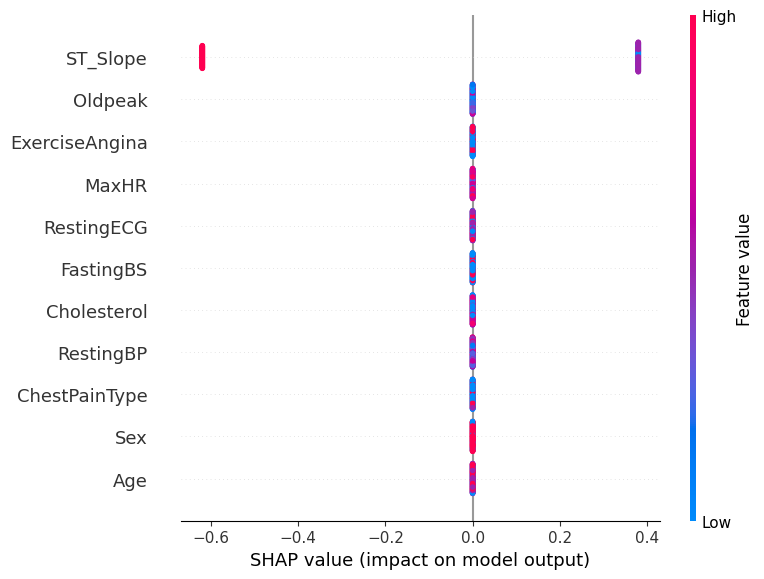

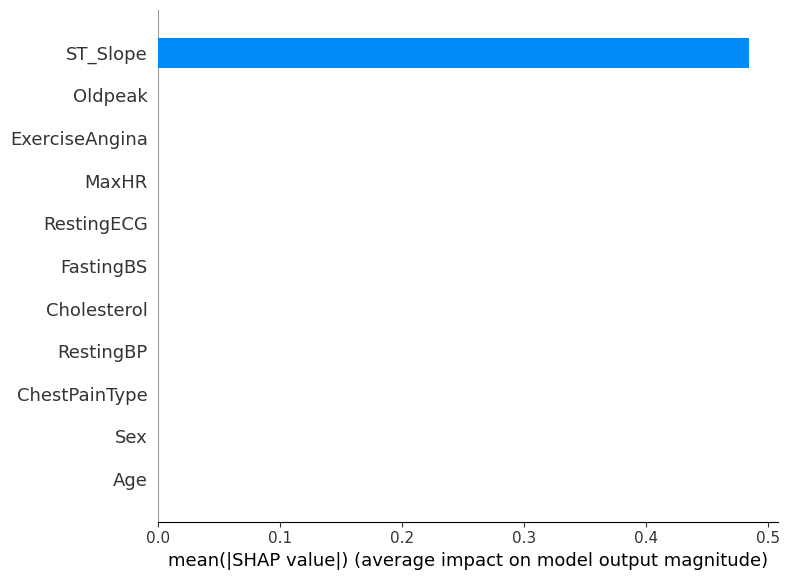

In [83]:
print('---------------------------------------Ada Boost-----------------------')
explain(classifier_adab, x_dev, x_test)

--------------------------Logistic Regression---------------------------------


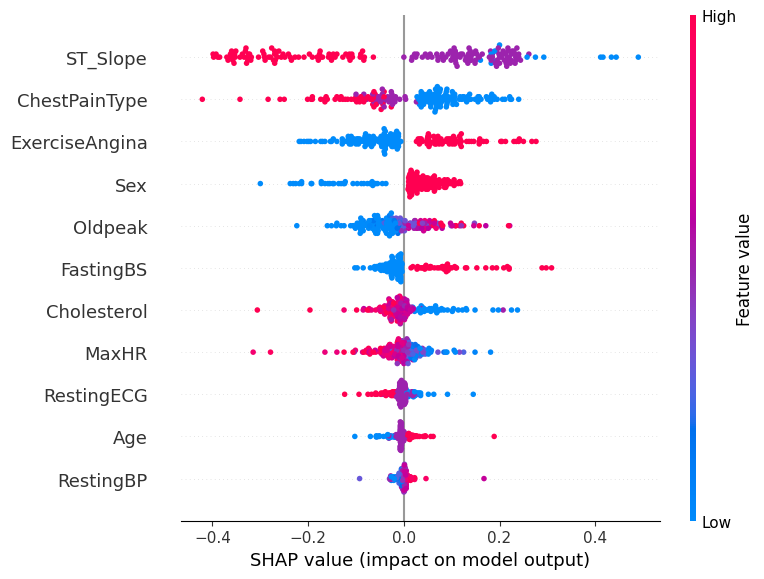

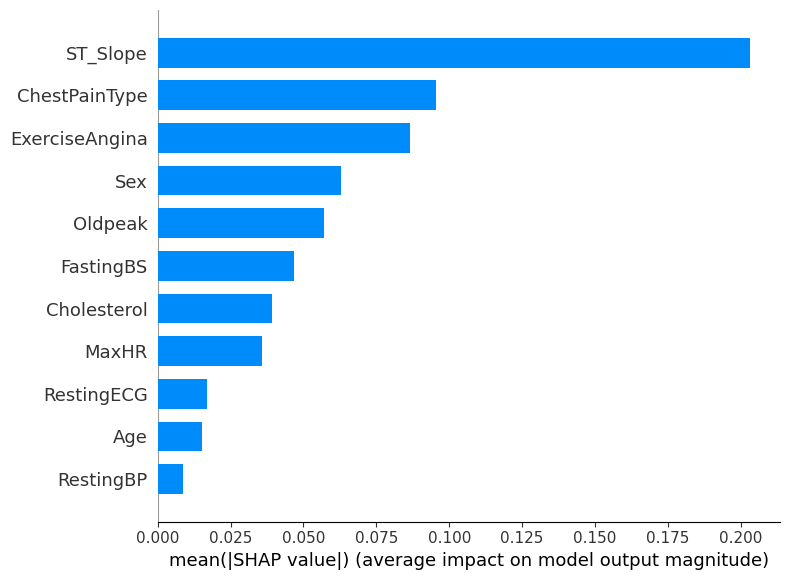

In [86]:
print('--------------------------Logistic Regression---------------------------------')
explain(classifier_lr, x_dev, x_test)

---------------------------------------MLP Classifier----------------------


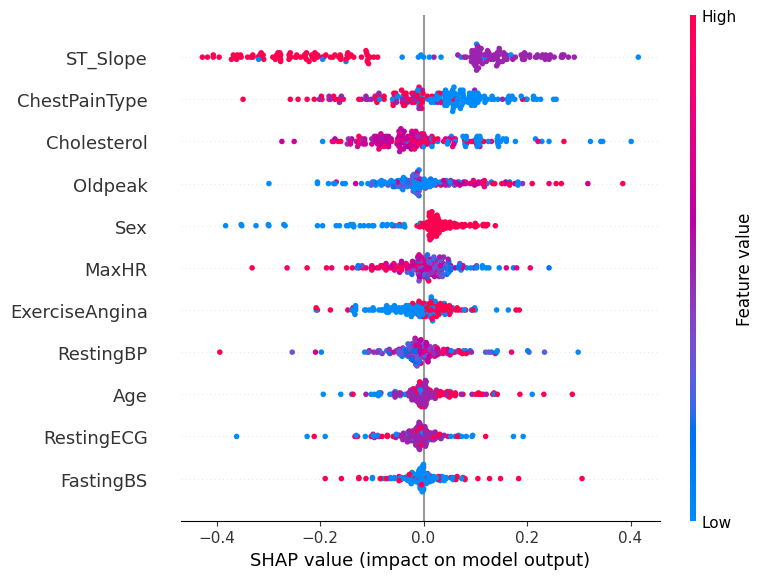

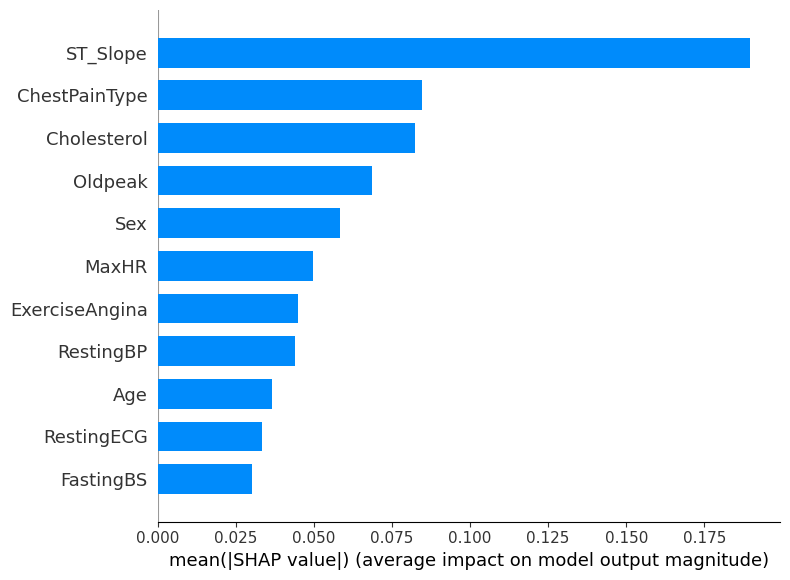

In [84]:
print('---------------------------------------MLP Classifier----------------------')
explain(classifier_mlp, x_dev, x_test)

-----------------------------K Nearest Neighbor-----------------------------


PermutationExplainer explainer: 185it [00:45,  3.22it/s]                         


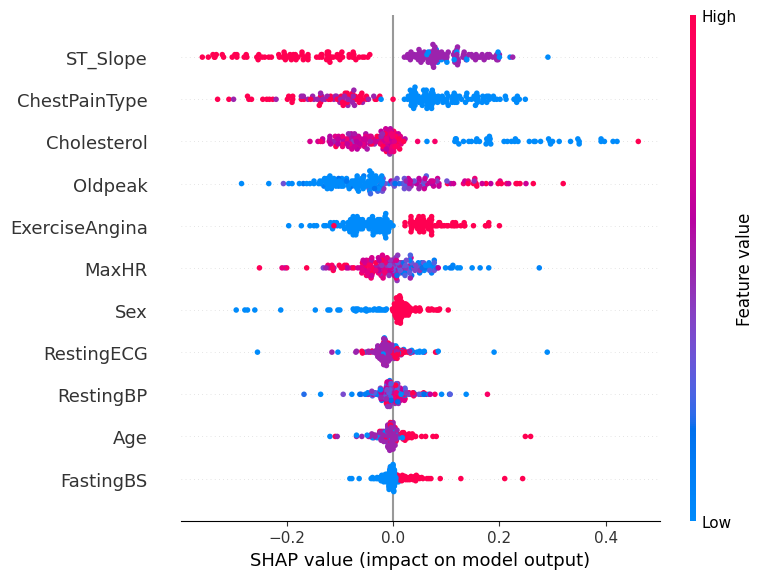

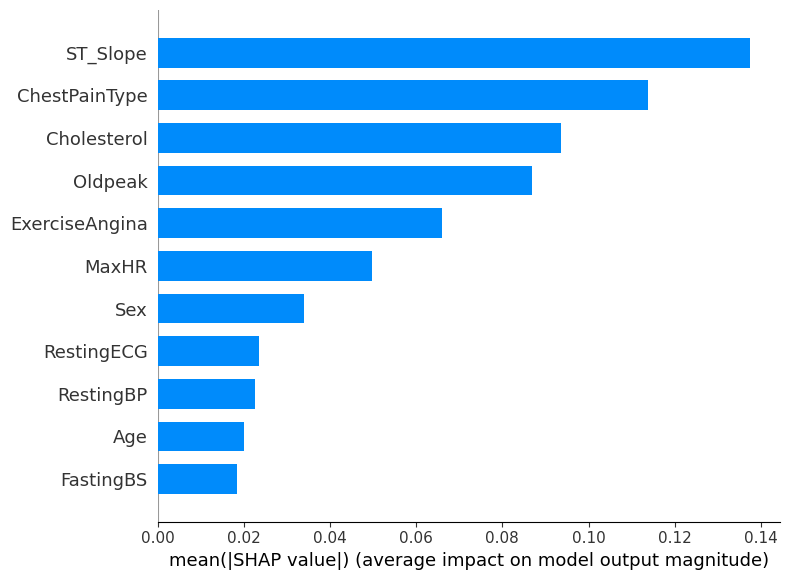

In [85]:
print('-----------------------------K Nearest Neighbor-----------------------------')
# explain(shap.Explainer(classifier_knn.predict, x_dev), x_test)
explain(classifier_knn, x_dev, x_test)
# # https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Census%20income%20classification%20with%20scikit-learn.html
# def f(x):
#     return classifier_knn.predict_proba(x)[:, 1]


# # med = X_train.median().values.reshape((1, X_train.shape[1]))

# explainer = shap.Explainer(f, med)
# shap_values = explainer(X_valid.iloc[0:1000, :])

## References
General resources used during development of the model.
Kaggle notebooks:
* Heart Disease Prediction using 9 models: https://kaggle.com/code/fahadrehman07/heart-disease-prediction-using-9-models
* https://kaggle.com/code/tanmay111999/heart-failure-prediction-cv-score-90-5-models
* https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem
* https://www.kaggle.com/code/durgancegaur/data-imbalance-eda-87-auc?scriptVersionId=88319036
Bias Mitigation
* https://fairlearn.org/main/auto_examples/plot_correlationremover_before_after.html

SHAP values
***
Models
* Gradient Boosting: # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
* MLP # https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
**